# Assignment 2: Segmentation from Superpixels

Name: **Paras Savnani**

UID:  **117396379**

Link to Google Drive : https://colab.research.google.com/drive/1jijBhSFIThSyxDF3V4ZZjDZAUthUJUbM?usp=sharing

**NOTE: The accuracy for the superpixel classifier could be much better if I had the compute capacity, I have trained for very less epochs (5) for the bonus question too. I think given more compute power and time this can give much better results.** 

Please submit a PDF containing all outputs to gradescope by **November 30, 3:30pm**




The goal of assignment 2 is to build a segmentation network, which uses SLIC Superpixels as input. In essense, it will be a classifier for superpixels. The end product is a system which, when given an image, computes superpixels and classifies each superpixel as one of the 9 classes of MSRC v1. 

From assignment 1, we already know why SLIC works differently from K-means and how to implement SLIC from scratch. 

This assignment is quite oepn-ended, i.e. we can realize the goal by at least two approaches, 
1. Rescaling every superpixels into 224X224 using resize functions. 
2. Borrow the idea of RoI pooling from Faster-RCNN object detector and use the roi_pool method in PyTorch.

Also, you are welcome to solve the assignment by other approaches as well. 



Here, we provide some ideas of the first method, which is reformulating the Superpixels semantic segmentation problem into an easier problem of image classification. There are basically three steps in the training stage. 

1. Dilate and save each superpixel region from SLIC output into image of size 224X224, alongwith the ground truth segments label. 
2. Build a couple of convolution layers to extract the deep features from each Superpixel patch image. Let the last layer be Fully connected layers.
3. Define the segmentation loss as multi-class classification loss and train a convolutional neural network based classifier.
4. During inference, we combine the classifier's predicted labels to form the whole input image's Superpixel segmentation results.

## Data
First, we download the MSRC labeled imaged database.

In [ ]:
!wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
!unzip --qq msrc_objcategimagedatabase_v1.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


We provide the following functions as helpers for plotting your results. Please pay attention to their signatures and outputs.

In [3]:
#All important functions to plot, same as assignment 1
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

def plot_image(im,title,xticks=[],yticks= [],cv2 = True):
    """
    im :Image to plot|
    title : Title of image 
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing 
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """
    plt.figure()
    plt.imshow(im[:,:,::-1])
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)

def superpixel_plot(im,seg,title = "Superpixels"):
    """
    Given an image (nXmX3) and pixelwise class mat (nXm), 
    1. Consider each class as a superpixel
    2. Calculate mean superpixel value for each class
    3. Replace the RGB value of each pixel in a class with the mean value  
    
    Inputs:
    im: Input image
    seg: Segmentation map
    title: Title of the plot 
    
    Output: None
    Creates a plot    
    """
    clust = np.unique(seg)
    mapper_dict = {i: im[seg == i].mean(axis = 0)/255. for i in clust}

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i]
    
    plot_image(seg_img,title)
    
    return     

Before you start to build a deep learning model, it is always advised for you to visualize and get familar with the images/segmentations in the dataset.

C:\Users\savna\AppData\Local\Temp/ipykernel_9252/542961338.py:10: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments_sample = slic(image_sample, n_segments=100, compactness=10)


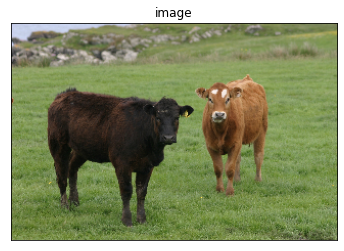

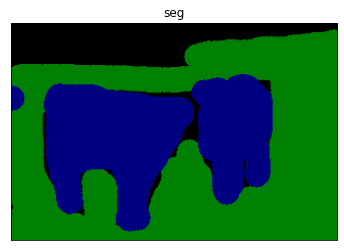

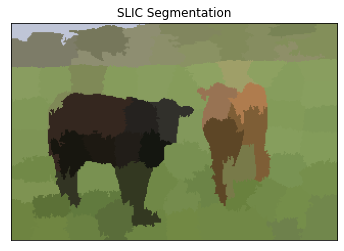

In [4]:
#  plot a sample image and its ground truth segments
image_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s.bmp')
seg_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s_GT.bmp')
plot_image(image_sample, 'image')
plot_image(seg_sample, 'seg')

#  run SLIC on the sample image and plot the corresponding SLIC segments
from skimage.segmentation import slic

segments_sample = slic(image_sample, n_segments=100, compactness=10)
superpixel_plot(image_sample, segments_sample, title = "SLIC Segmentation")
# print(segments_sample)

In [5]:
import cv2
from skimage.segmentation import slic
from IPython import embed
import os

current_directory = os.getcwd()
msrc_directory = current_directory + '/MSRC_ObjCategImageDatabase_v1'
print(msrc_directory)

F:\MEngg Robotics\CMSC828i\Assignment2/MSRC_ObjCategImageDatabase_v1


In [6]:
# Superpixel dataset preparation

# from Dataset_v1
SEG_LABELS_LIST_v1 = [
    {"id": 0, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 1,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 2,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 3,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 4,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 5,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 6,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 7, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 8, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 9, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": 0, "name": "horse",       "rgb_values": [128,   0,    128]},
    {"id": 0, "name": "water",       "rgb_values": [64,   128,    0]},
    {"id": 0, "name": "mountain",       "rgb_values": [64,   0,    0]},
    {"id": 0, "name": "sheep",       "rgb_values": [0,   128,    128]}]

# from Dataset_v2
SEG_LABELS_LIST_v2 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
    {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
    {"id": 6,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 7,  "name": "mountain",   "rgb_values": [64,  0,    0]},
    {"id": 8,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 9,  "name": "water",      "rgb_values": [64,  128,  0]},
    {"id": 10, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 11, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 12, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": 13, "name": "flower",     "rgb_values": [64,  128,  128]},
    {"id": 14, "name": "sign",       "rgb_values": [192, 128,  128]},
    {"id": 15, "name": "bird",       "rgb_values": [0,   64,   0]},
    {"id": 16, "name": "book",       "rgb_values": [128, 64,   0]},
    {"id": 17, "name": "chair",      "rgb_values": [0,   192,  0]},
    {"id": 18, "name": "road",       "rgb_values": [128, 64,   128]},
    {"id": 19, "name": "cat",        "rgb_values": [0,   192,  128]},
    {"id": 20, "name": "dog",        "rgb_values": [128, 192,  128]},
    {"id": 21, "name": "body",       "rgb_values": [64,  64,   0]},
    {"id": 22, "name": "boat",       "rgb_values": [192, 64,   0]}]

# create a map rgb_2_label, where mapping the ground truth 3-d array segmentation into a single ID label.
# {"rgb_value1" : "id1",
#  "rgb_value2" : "id2",.....,}
rgb_2_label = {}
for i in SEG_LABELS_LIST_v1:
    rgb_2_label[tuple(i['rgb_values'])] = i['id']

label_2_rgb = {}
for i in SEG_LABELS_LIST_v1:
    label_2_rgb[i['id']] = tuple(i['rgb_values'])


# Question 1: Superpixel Dataset (30 points) 

First, we dilate each superpixel and save the output superpixel patch from SLIC into 224X224 size image (after rescaling), alongwith the ground truth segments label. 

For the purpose of consistency, we adopt the existing SLIC implenmentation from the scikit-learn machine learning package.

Suggested algorithm: Save the superpixels along with their segmentation class. You could implement this as follows:

For each image
1. Get superpixels sp_i for image x. We adopt 100 segments in this assignment, 'segments = slic(image, n_segments=100, compactness=10)'.
2. For every superpixel sp_i in the image, \\
    2.1. find the smallest rectangle which can enclose sp_i <br>
    2.2. Dilate the rectangle by 3 pixels.<br>
    2.3. Get the same region from the segmentation image (from the file with similar name with *_GT). <br>The class for this sp_i is mode of segmentation classes in that same region.<br> Save the dilated region as npy (jpg is lossy for such small patches).<br>


Alternatively, you could create a single csv with columns segment patch location, class label for each sp_i of each image.<br>




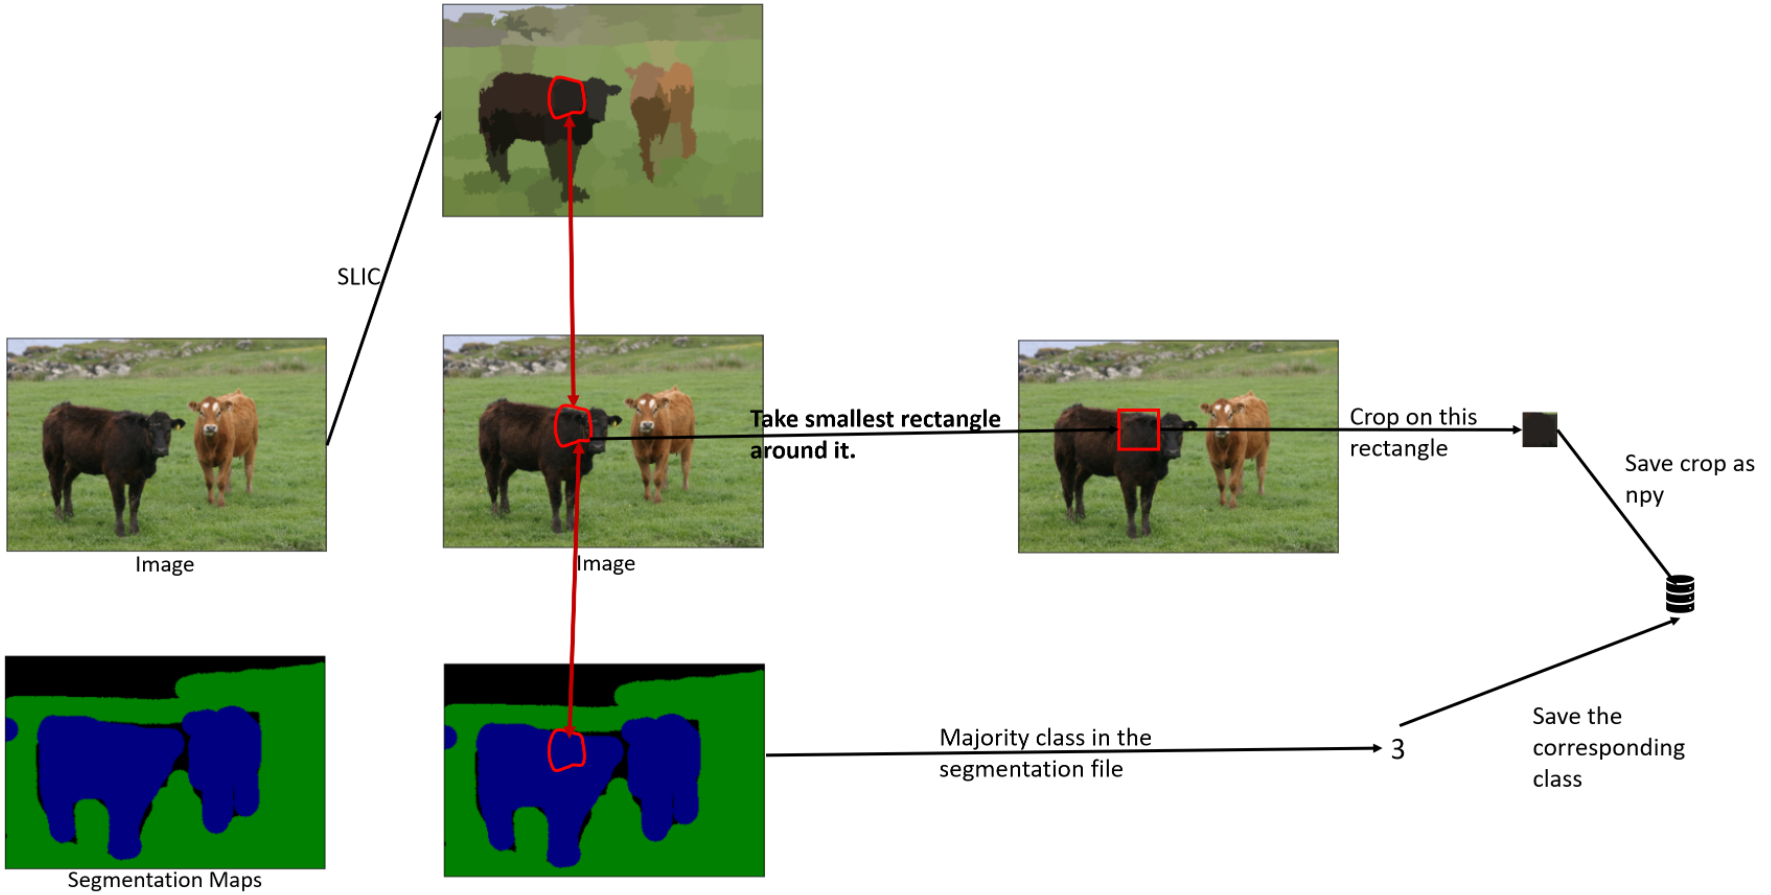

In [7]:
from skimage.measure import label
from skimage.measure import regionprops
from skimage.color import label2rgb

In [8]:
# !unzip dataset.zip

In [ ]:
!mkdir dataset
!mkdir dataset/images

The syntax of the command is incorrect.


In [ ]:
data_directory = current_directory + '/dataset/'

In [ ]:
#title
# run SLIC on each original images and save the (segment patch, ID label) pair
# segments = slic(image, n_segments=100, compactness=10) 
# it may take up to half an hour to process, depending on the hardware resources
# save the output file names to train.txt 
# Alternatively, you don't save the segment patch and ID label offline, instead, 
# you process them on the fly later.

def calc_mode(img):
    unq,count = np.unique(img.reshape(-1,img.shape[-1]), axis=0, return_counts=True)
    return unq[count.argmax()]


if os.path.exists('./datasets/train.txt'):
    os.remove('./datasets/train.txt')

with open(data_directory + '/labels.txt', 'w') as f:

    for filename in os.listdir(msrc_directory):
        if ('bmp' in filename) and ('GT' not in filename):

            image = cv2.imread(msrc_directory + '/' + filename)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            seg = cv2.imread(msrc_directory + '/' + filename.split('.')[0] + '_GT' + '.bmp')
            seg_rgb = cv2.cvtColor(seg, cv2.COLOR_BGR2RGB)
            segments = slic(image_rgb, n_segments=100, compactness=10)
            
            
            image_label_overlay = label2rgb(segments, image=image_rgb)
            # fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
            # ax.imshow(image_label_overlay)

            # Processing each image to extract rectangles from superpixels
            for region in regionprops(segments):
                minr, minc, maxr, maxc = region.bbox
                
                # Dilate the rectangle by 2 pixels - resolve indexing issues
                minr, minc, maxr, maxc = minr-1, minc-1, maxr+1, maxc+1
                if(minr < 0): minr = 0
                if(minc < 0): minc = 0
                if(maxr == image_rgb.shape[0]): maxr = image_rgb.shape[0]-1
                if(maxc == image_rgb.shape[1]): maxc = image_rgb.shape[1]-1
                

                # Cropping the image and segmap     
                bbox_img = image_rgb[minr:maxr, minc:maxc]
                bbox_seg = seg_rgb[minr:maxr, minc:maxc]

                # Calculating the mode of the cropped image
                mode = calc_mode(bbox_seg)
                label = rgb_2_label[tuple(mode)]

                # Resizing the image to 224*224
                bbox_img = cv2.resize(bbox_img, (224,224), interpolation = cv2.INTER_AREA)

                # Saving the resized image as .npy file and writing to the labels.txt file
                np.save(data_directory + 'images/' + f'{filename}_{regionprops(segments).index(region)}.npy', bbox_img)
                f.write(f'{filename}_{regionprops(segments).index(region)}.npy' + '\t' + str(label) + '\n')


C:\Users\savna\AppData\Local\Temp/ipykernel_940/1505246840.py:27: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = slic(image_rgb, n_segments=100, compactness=10)
C:\Users\savna\AppData\Local\Temp/ipykernel_940/1505246840.py:34: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  image_label_overlay = label2rgb(segments, image=image_rgb)


In [2]:
# !zip -r dataset.zip dataset

Now, we can define the dataset and dataloader.

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
from torchvision import transforms
import _pickle as pickle
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from torchvision import transforms, utils
import torch.nn.functional as F

# -------------
# Dataset class
# -------------
#
# ``torch.utils.data.Dataset`` is an abstract class representing a
# dataset.
# Your custom dataset should inherit ``Dataset`` and override the following
# methods:
#
# -  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
# -  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
#    be used to get sp_i sample
#
# Let's create a dataset class for our superpixel dataset. We will
# read the csv in ``__init__`` but leave the reading of images to
# ``__getitem__``. This is memory efficient because all the images are not
# stored in the memory at once but read as required.
#
# Sample of our dataset will be a dict
# ``{'superpixel image': image, 'superpixel class': class}``. Our dataset will take an
# optional argument ``transform`` so that any required processing can be
# applied on the sample. Remember to resize the image using ``transform``.

class SegmentationData(data.Dataset):

    def __init__(self, txt_file, img_dir, transform=None):
        self.ground_truth_values = self.preprocess(txt_file)
        self.img_dir = img_dir
        self.transform = transform
            
    def __len__(self):
        return len(self.ground_truth_values)
        
    
    def __getitem__(self, index):
        
        if torch.is_tensor(index):
            index = index.tolist()

        img_path = os.path.join(self.img_dir, self.ground_truth_values[index][0])
        image = np.load(img_path)
        # Remember this processing step
        image = np.clip(np.asarray(image, dtype=float)/255, 0, 1)
        label = self.ground_truth_values[index][1]
        label = int(label)
        

        if self.transform:
            image = self.transform(image)
        
        sample = {'superpixel_image': image, 'superpixel_class': torch.tensor(label, dtype=torch.long)}
        return sample  
    
    def image_name(self,index):
        return self.ground_truth_values[index][0]

    def preprocess(self,txt_file):
        data = open(txt_file, encoding='utf8').read().split('\n')
        data = [line for line in data]                           
        data = [item.split('\t') for item in data]
        return data[:-1] #Drop last item

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return torch.from_numpy(image)
  

## IMPORTANT

Show some outputs! Choose 1 image. For that image, plot the image, along with the superpixel map for the image, as you did for Assignment 1. Then, show the first 10 superpixel patches for the image, retrieved from your dataset.

The output for this portion will be 12 images, displayed below your code below.

1_10_s.bmp_0.npy


C:\Users\savna\AppData\Local\Temp/ipykernel_25356/2432050839.py:12: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments_sample = slic(image_sample, n_segments=100, compactness=10)


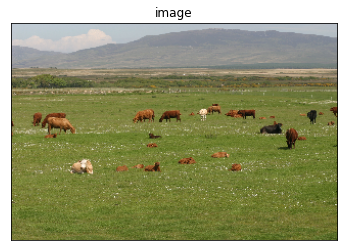

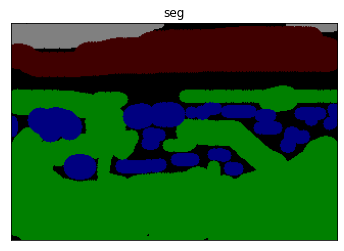

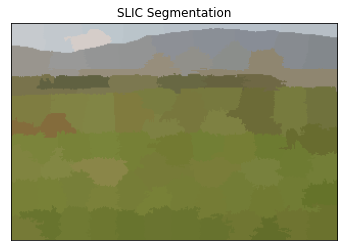

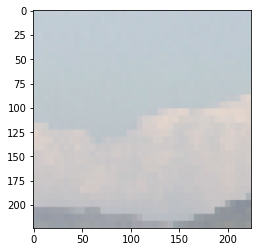

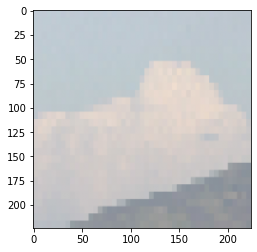

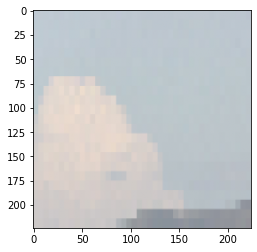

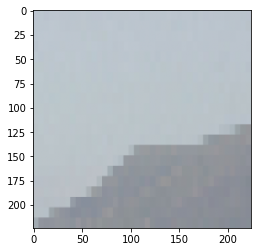

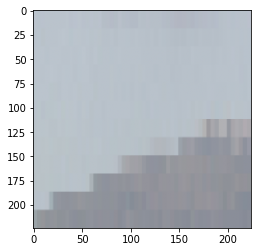

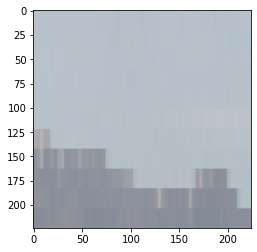

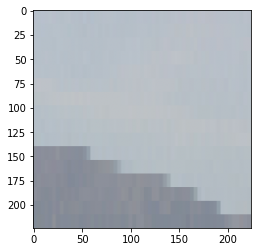

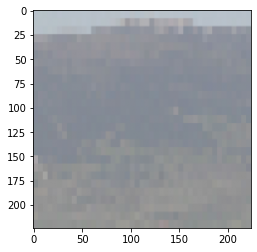

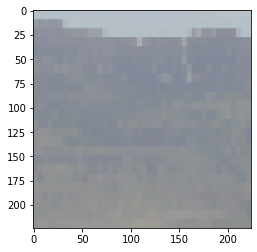

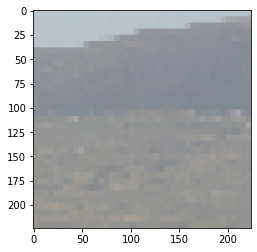

In [ ]:
### YOUR CODE TO PLOT 12 images (GT + superpixel map + first 10 superpixels) ###
txt_file =  data_directory + '/labels.txt'
img_dir = data_directory + '/images'
dataset = SegmentationData(txt_file, img_dir)
print(dataset.image_name(0))

image_sample = cv2.imread(msrc_directory + '/1_10_s.bmp')
seg_sample = cv2.imread(msrc_directory + '/1_10_s_GT.bmp')
plot_image(image_sample, 'image')
plot_image(seg_sample, 'seg')

segments_sample = slic(image_sample, n_segments=100, compactness=10)
superpixel_plot(image_sample, segments_sample, title = "SLIC Segmentation")
plt.show()

# Printing the first 10 superpixels:
for i in range(10):
    plt.imshow(dataset[i]['superpixel_image'])
    plt.show()

In [ ]:
# model = models.vgg19(pretrained=True)
# model.classifier

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\savna/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

## Question 2: Deep Network (10 points)

We use a pre-trained network (like VGG) and replace the last few layers with a fully connected layer.

In [ ]:
# Model definition
class SegmentationNN(nn.Module):
    def __init__(self):
        super(SegmentationNN, self).__init__()
        self.model = models.vgg19(pretrained=True)
        self.model.classifier = nn.Sequential(
                  nn.Linear(512*7*7, 2048),
                  nn.LeakyReLU(True),
                  nn.Dropout(0.5),
                  nn.Linear(2048, 500),
                  nn.LeakyReLU(True),
                  nn.Dropout(0.7),
                  nn.Linear(500, 10))
        
        for param in self.model.features.parameters():
            param.requires_grad = False
        

    def forward(self, input):
        output = self.model(input)
        return output


## Question 3: Optimizer (10 points) 

Finally, we define the classification loss and optimizer such that we can learn a superpixel classifier from the backproporgation algorithm. 

In [ ]:
from tqdm import tqdm

# Optimizer 
class Solver(object):
    def __init__(self, model, epochs, trainloader, device, lr=0.001):
        self.criterion = nn.CrossEntropyLoss()
        self.model = model
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-5)
        self.epochs = epochs
        self.trainloader = trainloader 
        self.device = device
        
    def train(self):
        for epoch in range(self.epochs):  # loop over the dataset multiple times

            running_loss = 0.0
            for i, sample_batch in enumerate(tqdm(self.trainloader)):
                image_batch = sample_batch['superpixel_image'].to(self.device)
                label_batch = sample_batch['superpixel_class'].to(self.device)
                label_batch = F.one_hot(label_batch, num_classes=10)
                label_batch = label_batch.float()
                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.model(image_batch.float())
                loss = self.criterion(outputs, label_batch)
                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()
                if i % 20 == 19:    # print every 20 mini-batches
                    print('[Epoch: %d, Iteration: %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 20))
                    running_loss = 0.0
                    
            # Saving intermediate models after 20 epochs
            if epoch>20 and epoch%2 == 0:
                torch.save(model.state_dict(), current_directory + f'/models/seg_network_{epoch}.pt')
                
        print('Finished Training')

## Question 4: Putting it together (50 points) 

Start to train your network and observe the loss in time.
During the inference stage, combine the SLIC Superpixels' predicted labels to form the whole input image's Superpixel segmentation results.

1. Randomly split the whole dataset into train and test subset (80:20 split is fine), show us the training loss of the classifier after every epoch, and then training accuracy and test accuracy of the classifier after training.
2. At least one visualization on the test segmentation map vs. ground truth segmentation map.

In [ ]:
# load the data
txt_file =  data_directory + '/labels.txt'
img_dir = data_directory + '/images'
transform = transforms.Compose([ToTensor(), transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])

# Check normalize transform
dataset = SegmentationData(txt_file, img_dir, transform)

# data loader
batch_size = 32
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)


# model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = SegmentationNN().to(device)
solver = Solver(model, 35, trainloader, device, 0.001)

# train the model
# solver.train()

cuda:0


In [ ]:
# !mkdir models
PATH = current_directory + '/models/seg_network_32.pt'
# torch.save(model.state_dict(), PATH

In [ ]:
model.load_state_dict(torch.load(PATH))
model.eval()

SegmentationNN(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
     

In [ ]:
# Overfitting in model - Try simplifying the network, weigth decay, dropout !
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for sample_batched in testloader:
        images, labels = sample_batched['superpixel_image'].to(device), sample_batched['superpixel_class'].to(device)
        # calculate outputs by running images through the network
        outputs = model(images.float())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 81 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


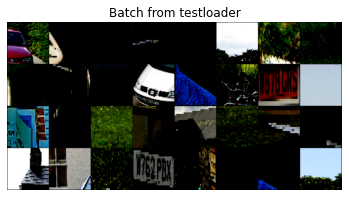

tensor([8, 0, 0, 0, 0, 5, 0, 2, 2, 6, 3, 8, 0, 0, 8, 5, 0, 0, 2, 0, 1, 2, 6, 0,
        1, 1, 2, 8, 1, 5, 0, 5])


In [ ]:
# Visualizing test data
dataiter = iter(testloader)
data = dataiter.next()
image_batch, label_batch  = data['superpixel_image'], data['superpixel_class']

# show images
grid = utils.make_grid(image_batch)
plt.figure()
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.title('Batch from testloader')
plt.axis('off')
plt.ioff()
plt.show()
# print labels
print(label_batch)

C:\Users\savna\AppData\Local\Temp/ipykernel_25356/584803776.py:7: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments_sample = slic(image_rgb, n_segments=100, compactness=10)


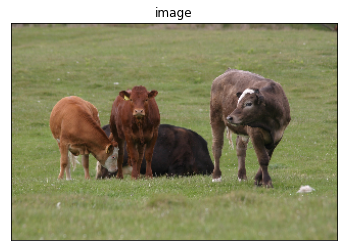

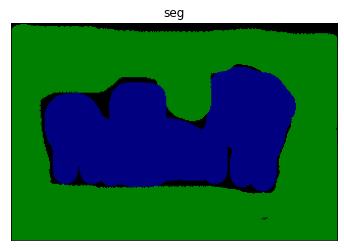

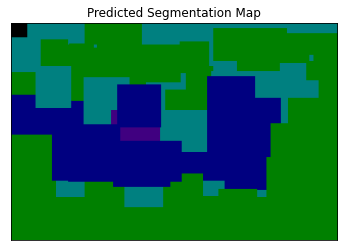

Pixel Accuracy:  72.84330985915493


In [ ]:
# Evaluation
image_rgb = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_14_s.bmp')
seg_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_14_s_GT.bmp')
plot_image(image_rgb, 'image')
plot_image(seg_sample, 'seg')

segments_sample = slic(image_rgb, n_segments=100, compactness=10)
superpixel_plot(image_rgb, segments_sample, title = "SLIC Segmentation")
# Processing each image to extract rectangles from superpixels

superpixel_data = []
for region in regionprops(segments_sample):
    minr, minc, maxr, maxc = region.bbox

    # Dilate the rectangle by 2 pixels - resolve indexing issues
    minr, minc, maxr, maxc = minr-1, minc-1, maxr+1, maxc+1
    if(minr < 0): minr = 0
    if(minc < 0): minc = 0
    if(maxr == image_rgb.shape[0]): maxr = image_rgb.shape[0]-1
    if(maxc == image_rgb.shape[1]): maxc = image_rgb.shape[1]-1

    # Cropping the image and segmap     
    bbox_img = image_rgb[minr:maxr, minc:maxc]

    # Resizing the image to 224*224
    bbox_img = cv2.resize(bbox_img, (224,224), interpolation = cv2.INTER_AREA)
    bbox_img = np.clip(np.asarray(bbox_img, dtype=float)/255, 0, 1)
    # Applying the transforms
    bbox_img = transform(bbox_img)
  
    superpixel_data.append({'superpixel_image': bbox_img, 'superpixel_location': (minr, minc, maxr, maxc)})

dataloader = DataLoader(superpixel_data, batch_size=32, shuffle=True, num_workers=0)

predicted_seg_map = np.zeros(image_rgb.shape, dtype=np.uint8)

with torch.no_grad():
    for sample_batched in dataloader:
        images, location = sample_batched['superpixel_image'].to(device), sample_batched['superpixel_location']
        # calculate outputs by running images through the network
        outputs = model(images.float())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        for i in range(len(images)):
            rgb = label_2_rgb[int(f'{predicted[i]}')]
            minr, minc, maxr, maxc = location[0][i], location[1][i], location[2][i], location[3][i]
            predicted_seg_map[minr:maxr, minc:maxc, :] = rgb

seg_sample = cv2.cvtColor(seg_sample, cv2.COLOR_BGR2RGB)
# print(np.unique(seg_sample.reshape(-1,seg_sample.shape[-1]), axis=0, return_counts=True))
# print(np.unique(predicted_seg_map.reshape(-1,predicted_seg_map.shape[-1]), axis=0, return_counts=True))
plt.imshow(predicted_seg_map)
plt.title('Predicted Segmentation Map')
plt.show()
# Pixel accuracy 
Total_pixels = seg_sample.shape[0]*seg_sample.shape[1]

mask = np.all(predicted_seg_map == seg_sample, axis=2)
# print(mask)
TP = np.where(mask==True)
print("Pixel Accuracy: ", (len(TP[0])/Total_pixels)*100)

## Bonus Questions (20 points):

IMPORTANT: No matter which option you choose, you can earn a maximum of 20 points for this section.

We always want to increase the classifier accuracy and achieve a better performance by building a complicated deep learning model. There are a lot of tricks which are very popular and work in practice. Try to implement either of following two,

1. Could you effictively fuse different deep features from multiple layers in your network? You are welcome to use the pretrained network. Does your network achieve a better accuracy? There are a lot of exploration in the literature, including ION (Inside-Outside Net) [1], Hypercolumns [2], and PixelNet [3]. The following figure illustrates ION architecture combining features from different layers. Can you do similar thing for our Superpixel classifier?

2. Could you build a Multi-resolution network to explore the effectiveness of the multi-scale on the task of Superpixels segmentation? By multi-scale, we mean multiple resolutions of superpixels. See [4] for an example.

[1] Inside-Outside Net: Detecting Objects in Context with Skip Pooling and Recurrent Neural Networks

[2] Hypercolumns for Object Segmentation and Fine-grained Localization

[3] PixelNet: Representationofthe pixels, by the pixels, and for the pixels

[4] Feedforward semantic segmentation with zoom-out features

In [9]:
data_directory = current_directory + '/multilevel_dataset/'

In [2]:
# TODO: Bonus - 2. We will try to build a multi resolution network
# -Capture the boxes at multiple levels 
# Save image as (4, 3, 224, 224) 
# Dataset Generation
from tqdm import tqdm

def calc_mode(img):
    unq,count = np.unique(img.reshape(-1,img.shape[-1]), axis=0, return_counts=True)
    return unq[count.argmax()]

with open(data_directory + '/labels.txt', 'w') as f:

    for filename in tqdm(os.listdir(msrc_directory)):
        if ('bmp' in filename) and ('GT' not in filename):

            image = cv2.imread(msrc_directory + '/' + filename)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            seg = cv2.imread(msrc_directory + '/' + filename.split('.')[0] + '_GT' + '.bmp')
            seg_rgb = cv2.cvtColor(seg, cv2.COLOR_BGR2RGB)
            segments = slic(image_rgb, n_segments=100, compactness=10)
            

            image_label_overlay = label2rgb(segments, image=image_rgb)
           
            # Processing each image to extract rectangles from superpixels
            for region in regionprops(segments):
                minr, minc, maxr, maxc = region.bbox
                
                # print(minr, minc, maxr, maxc)
                
                # Local zoom - Superpixel level__________________________________ 
                # Cropping the image and segmap     
                bbox_img_local = image_rgb[minr:maxr, minc:maxc]
                bbox_img_local = cv2.resize(bbox_img_local, (224,224), interpolation = cv2.INTER_AREA)
                
                bbox_seg = seg_rgb[minr:maxr, minc:maxc]

                # Calculating the mode of the cropped image to decide the class label
                mode = calc_mode(bbox_seg)
                label = rgb_2_label[tuple(mode)]
                
                # Proximal Zoom ~ 9 Superpixels Area__________________________________
                pminr, pminc, pmaxr, pmaxc = minr-25, minc-25, maxr+25, maxc+25
                if(pminr < 0): pminr = 0
                if(pminc < 0): pminc = 0
                if(pmaxr == image_rgb.shape[0]): pmaxr = image_rgb.shape[0]-1
                if(pmaxc == image_rgb.shape[1]): pmaxc = image_rgb.shape[1]-1
                    
                bbox_img_proximal = image_rgb[pminr:pmaxr, pminc:pmaxc]
                bbox_img_proximal = cv2.resize(bbox_img_proximal, (224,224), interpolation = cv2.INTER_AREA)
                
                # Distant Zoom ~ 25 Superpixels Area__________________________________
                dminr, dminc, dmaxr, dmaxc = minr-50, minc-50, maxr+50, maxc+50
                if(dminr < 0): dminr = 0
                if(dminc < 0): dminc = 0
                if(dmaxr == image_rgb.shape[0]): dmaxr = image_rgb.shape[0]-1
                if(dmaxc == image_rgb.shape[1]): dmaxc = image_rgb.shape[1]-1
                    
                bbox_img_distant = image_rgb[dminr:dmaxr, dminc:dmaxc]
                bbox_img_distant = cv2.resize(bbox_img_distant, (224,224), interpolation = cv2.INTER_AREA)
                
                # Global Zoom ~ Full image_______________________________________
                bbox_img_global = image_rgb
                bbox_img_global = cv2.resize(bbox_img_global, (224,224), interpolation = cv2.INTER_AREA)
                
                bbox_combined = np.stack([bbox_img_local, bbox_img_proximal, bbox_img_distant, bbox_img_global], axis=0)
                
                # Visualizing the different Zoom Levels for a single superpixel
#                 if regionprops(segments).index(region) == 1:
#                     plot_image(bbox_combined[0], "superpixel")
#                     plot_image(bbox_combined[1], "proximal zoom")
#                     plot_image(bbox_combined[2], "distant zoom")
#                     plot_image(bbox_combined[3], "global zoom")
            
                
                # Saving the resized image as .npy file and writing to the labels.txt file
                np.save(data_directory + 'images/' + f'{filename}_{regionprops(segments).index(region)}.npy', bbox_combined)
                f.write(f'{filename}_{regionprops(segments).index(region)}.npy' + '\t' + str(label) + '\n')
       

NameError: name 'data_directory' is not defined

In [13]:
# Dataset Class
import os
import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
from torchvision import transforms
import _pickle as pickle
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from torchvision import transforms, utils
import torch.nn.functional as F

class SegmentationData(data.Dataset):

    def __init__(self, txt_file, img_dir, transform = None):
        self.ground_truth_values = self.preprocess(txt_file)
        self.img_dir = img_dir
        self.transform = transform
            
    def __len__(self):
        return len(self.ground_truth_values)
        
    
    def __getitem__(self, index):
        
        if torch.is_tensor(index):
            index = index.tolist()

        img_path = os.path.join(self.img_dir, self.ground_truth_values[index][0])
        image = np.load(img_path)
        # Remember this processing step
        image = np.clip(np.asarray(image, dtype=float)/255, 0, 1)
        label = self.ground_truth_values[index][1]
        label = int(label)
        
        if self.transform:
            image = self.transform(image)
        
        sample = {'superpixel_image': image, 'superpixel_class': torch.tensor(label, dtype=torch.long)}
        return sample  
    
    def image_name(self,index):
        return self.ground_truth_values[index][0]

    def preprocess(self,txt_file):
        data = open(txt_file, encoding='utf8').read().split('\n')
        data = [line for line in data]                           
        data = [item.split('\t') for item in data]
        return data[:-1] #Drop last item

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        # swap color axis because
        # numpy image: 4 x H x W x C
        # torch image: 4 x C x H x W
        image = image.transpose((0, 3, 1, 2))
        return torch.from_numpy(image)
    
class Normalize(object):
    """Normalizes the custom image"""
    
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    
    def __call__(self, image_tensor):
        # image tensor shape: (4 x C x H x W)
        
        norm_image_tensor = F.normalize(image_tensor[0,:,:,:], self.mean, self.std)
        norm_image_tensor = torch.unsqueeze(norm_image_tensor, dim=0) 
        
        for i in range(1, 4):
            new_tensor = torch.unsqueeze(F.normalize(image_tensor[i,:,:,:], self.mean, self.std), dim=0)
            norm_image_tensor = torch.cat([norm_image_tensor, new_tensor], 0)
            
        return norm_image_tensor


In [14]:
# Model definition
class SegmentationNN(nn.Module):
    def __init__(self):
        super(SegmentationNN, self).__init__()
        self.model = models.vgg19(pretrained=True)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.model.classifier = nn.Sequential(
                  nn.Linear(4*512*7*7, 1024),
                  nn.LeakyReLU(True),
                  nn.Dropout(0.5),
                  nn.Linear(1024, 500),
                  nn.LeakyReLU(True),
                  nn.Dropout(0.5),
                  nn.Linear(500, 10))
        
        for param in self.model.features.parameters():
            param.requires_grad = False
        

    def forward(self, input):
        # Here input is (32 x 4 x 224 x 224 x 3)
        
        # input all images seperately
        input_image = input[:, 0, :, :, :]
        combined_features = self.model.features(input_image)
        
        for i in range(1, 4):
            input_image = input[:, i, :, :, :]
            output_features = self.model.features(input_image)
            combined_features = torch.cat((combined_features, output_features), 1)
        
        combined_features = self.avgpool(combined_features)
        combined_features = torch.flatten(combined_features, 1)
        output = self.model.classifier(combined_features)
        
        return output

# tensor = torch.zeros((32, 4, 3, 224, 224))
# model = SegmentationNN()
# print(model.forward(tensor).shape)

In [15]:
# Optimizer 
from tqdm import tqdm

class Solver(object):
    def __init__(self, model, epochs, trainloader, device, lr=0.001):
        self.criterion = nn.CrossEntropyLoss()
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-5)
        self.epochs = epochs
        self.trainloader = trainloader 
        self.device = device
        
    def train(self):
        for epoch in range(self.epochs):  # loop over the dataset multiple times

            running_loss = 0.0
            for i, sample_batch in enumerate(tqdm(self.trainloader)):
                image_batch = sample_batch['superpixel_image'].to(self.device)
                label_batch = sample_batch['superpixel_class'].to(self.device)
                label_batch = F.one_hot(label_batch, num_classes=10)
                label_batch = label_batch.float()
                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.model(image_batch.float())
                loss = self.criterion(outputs, label_batch)
                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()
                if i % 20 == 19:    # print every 20 mini-batches
                    print('[Epoch: %d, Iteration: %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 20))
                    running_loss = 0.0
                    
            # Saving intermediate models after 20 epochs
            if epoch>10 and epoch%2 == 0:
                torch.save(self.model.state_dict(), current_directory + f'/models/multi_seg_network_{epoch}.pt')
                
        print('Finished Training')

In [16]:
# load the data
txt_file =  data_directory + 'labels.txt'
img_dir = data_directory + 'images'

print(txt_file)
transform = transforms.Compose([ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Check normalize transform
dataset = SegmentationData(txt_file, img_dir, transform)

# data loader
batch_size = 32
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)


# model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = SegmentationNN().to(device)
solver = Solver(model, 25, trainloader, device, 0.001)

# train the model
# solver.train()

F:\MEngg Robotics\CMSC828i\Assignment2/multilevel_dataset/labels.txt
cuda:0


  6%|████▌                                                                            | 20/357 [00:32<07:41,  1.37s/it]

[Epoch: 1, Iteration:    20] loss: 12.996


 11%|█████████                                                                        | 40/357 [01:00<07:15,  1.37s/it]

[Epoch: 1, Iteration:    40] loss: 17.704


 17%|█████████████▌                                                                   | 60/357 [01:27<06:49,  1.38s/it]

[Epoch: 1, Iteration:    60] loss: 18.459


 22%|██████████████████▏                                                              | 80/357 [01:55<06:31,  1.41s/it]

[Epoch: 1, Iteration:    80] loss: 14.985


 28%|██████████████████████▍                                                         | 100/357 [02:22<05:45,  1.35s/it]

[Epoch: 1, Iteration:   100] loss: 19.305


 34%|██████████████████████████▉                                                     | 120/357 [02:49<05:26,  1.38s/it]

[Epoch: 1, Iteration:   120] loss: 18.566


 39%|███████████████████████████████▎                                                | 140/357 [03:17<05:01,  1.39s/it]

[Epoch: 1, Iteration:   140] loss: 18.712


 45%|███████████████████████████████████▊                                            | 160/357 [03:45<04:44,  1.44s/it]

[Epoch: 1, Iteration:   160] loss: 15.645


 50%|████████████████████████████████████████▎                                       | 180/357 [04:13<04:05,  1.39s/it]

[Epoch: 1, Iteration:   180] loss: 14.952


 56%|████████████████████████████████████████████▊                                   | 200/357 [04:40<03:31,  1.35s/it]

[Epoch: 1, Iteration:   200] loss: 14.138


 62%|█████████████████████████████████████████████████▎                              | 220/357 [05:07<03:03,  1.34s/it]

[Epoch: 1, Iteration:   220] loss: 15.812


 67%|█████████████████████████████████████████████████████▊                          | 240/357 [05:35<02:42,  1.39s/it]

[Epoch: 1, Iteration:   240] loss: 15.590


 73%|██████████████████████████████████████████████████████████▎                     | 260/357 [06:03<02:15,  1.39s/it]

[Epoch: 1, Iteration:   260] loss: 13.075


 78%|██████████████████████████████████████████████████████████████▋                 | 280/357 [06:31<01:47,  1.40s/it]

[Epoch: 1, Iteration:   280] loss: 13.140


 84%|███████████████████████████████████████████████████████████████████▏            | 300/357 [06:59<01:19,  1.39s/it]

[Epoch: 1, Iteration:   300] loss: 12.345


 90%|███████████████████████████████████████████████████████████████████████▋        | 320/357 [07:26<00:51,  1.39s/it]

[Epoch: 1, Iteration:   320] loss: 13.777


 95%|████████████████████████████████████████████████████████████████████████████▏   | 340/357 [07:53<00:22,  1.35s/it]

[Epoch: 1, Iteration:   340] loss: 14.380


  6%|████▌                                                                            | 20/357 [00:24<06:47,  1.21s/it]

[Epoch: 2, Iteration:    20] loss: 11.844


 11%|█████████                                                                        | 40/357 [00:48<06:23,  1.21s/it]

[Epoch: 2, Iteration:    40] loss: 7.866


 17%|█████████████▌                                                                   | 60/357 [01:12<05:52,  1.19s/it]

[Epoch: 2, Iteration:    60] loss: 13.314


 22%|██████████████████▏                                                              | 80/357 [01:36<05:49,  1.26s/it]

[Epoch: 2, Iteration:    80] loss: 11.626


 28%|██████████████████████▍                                                         | 100/357 [02:00<05:12,  1.22s/it]

[Epoch: 2, Iteration:   100] loss: 8.877


 34%|██████████████████████████▉                                                     | 120/357 [02:25<04:48,  1.22s/it]

[Epoch: 2, Iteration:   120] loss: 10.869


 39%|███████████████████████████████▎                                                | 140/357 [02:49<04:18,  1.19s/it]

[Epoch: 2, Iteration:   140] loss: 9.939


 45%|███████████████████████████████████▊                                            | 160/357 [03:13<04:00,  1.22s/it]

[Epoch: 2, Iteration:   160] loss: 10.798


 50%|████████████████████████████████████████▎                                       | 180/357 [03:38<03:37,  1.23s/it]

[Epoch: 2, Iteration:   180] loss: 11.168


 56%|████████████████████████████████████████████▊                                   | 200/357 [04:03<03:14,  1.24s/it]

[Epoch: 2, Iteration:   200] loss: 12.343


 62%|█████████████████████████████████████████████████▎                              | 220/357 [04:27<02:47,  1.23s/it]

[Epoch: 2, Iteration:   220] loss: 11.512


 67%|█████████████████████████████████████████████████████▊                          | 240/357 [04:52<02:21,  1.21s/it]

[Epoch: 2, Iteration:   240] loss: 14.208


 73%|██████████████████████████████████████████████████████████▎                     | 260/357 [05:16<01:59,  1.24s/it]

[Epoch: 2, Iteration:   260] loss: 14.755


 78%|██████████████████████████████████████████████████████████████▋                 | 280/357 [05:41<01:35,  1.24s/it]

[Epoch: 2, Iteration:   280] loss: 10.973


 84%|███████████████████████████████████████████████████████████████████▏            | 300/357 [06:06<01:10,  1.24s/it]

[Epoch: 2, Iteration:   300] loss: 11.316


 90%|███████████████████████████████████████████████████████████████████████▋        | 320/357 [06:30<00:43,  1.18s/it]

[Epoch: 2, Iteration:   320] loss: 10.737


 95%|████████████████████████████████████████████████████████████████████████████▏   | 340/357 [06:55<00:20,  1.23s/it]

[Epoch: 2, Iteration:   340] loss: 12.943


  6%|████▌                                                                            | 20/357 [00:24<06:55,  1.23s/it]

[Epoch: 3, Iteration:    20] loss: 7.641


 11%|█████████                                                                        | 40/357 [00:49<06:29,  1.23s/it]

[Epoch: 3, Iteration:    40] loss: 12.355


 17%|█████████████▌                                                                   | 60/357 [01:13<06:04,  1.23s/it]

[Epoch: 3, Iteration:    60] loss: 8.382


 22%|██████████████████▏                                                              | 80/357 [01:38<05:40,  1.23s/it]

[Epoch: 3, Iteration:    80] loss: 11.524


 28%|██████████████████████▍                                                         | 100/357 [02:03<05:16,  1.23s/it]

[Epoch: 3, Iteration:   100] loss: 10.953


 34%|██████████████████████████▉                                                     | 120/357 [02:28<04:52,  1.24s/it]

[Epoch: 3, Iteration:   120] loss: 11.337


 39%|███████████████████████████████▎                                                | 140/357 [02:52<04:25,  1.22s/it]

[Epoch: 3, Iteration:   140] loss: 12.301


 45%|███████████████████████████████████▊                                            | 160/357 [03:17<04:03,  1.24s/it]

[Epoch: 3, Iteration:   160] loss: 9.019


 50%|████████████████████████████████████████▎                                       | 180/357 [03:41<03:37,  1.23s/it]

[Epoch: 3, Iteration:   180] loss: 13.839


 56%|████████████████████████████████████████████▊                                   | 200/357 [04:06<03:11,  1.22s/it]

[Epoch: 3, Iteration:   200] loss: 16.086


 62%|█████████████████████████████████████████████████▎                              | 220/357 [04:30<02:44,  1.20s/it]

[Epoch: 3, Iteration:   220] loss: 24.389


 67%|█████████████████████████████████████████████████████▊                          | 240/357 [04:54<02:20,  1.20s/it]

[Epoch: 3, Iteration:   240] loss: 19.786


 73%|██████████████████████████████████████████████████████████▎                     | 260/357 [05:19<01:59,  1.23s/it]

[Epoch: 3, Iteration:   260] loss: 22.088


 78%|██████████████████████████████████████████████████████████████▋                 | 280/357 [05:44<01:35,  1.24s/it]

[Epoch: 3, Iteration:   280] loss: 25.657


 84%|███████████████████████████████████████████████████████████████████▏            | 300/357 [06:08<01:09,  1.23s/it]

[Epoch: 3, Iteration:   300] loss: 26.004


 90%|███████████████████████████████████████████████████████████████████████▋        | 320/357 [06:33<00:44,  1.21s/it]

[Epoch: 3, Iteration:   320] loss: 20.046


 95%|████████████████████████████████████████████████████████████████████████████▏   | 340/357 [06:57<00:20,  1.19s/it]

[Epoch: 3, Iteration:   340] loss: 31.118


  6%|████▌                                                                            | 20/357 [00:24<06:54,  1.23s/it]

[Epoch: 4, Iteration:    20] loss: 23.486


 11%|█████████                                                                        | 40/357 [00:48<06:24,  1.21s/it]

[Epoch: 4, Iteration:    40] loss: 20.898


 17%|█████████████▌                                                                   | 60/357 [01:13<06:03,  1.22s/it]

[Epoch: 4, Iteration:    60] loss: 27.842


 22%|██████████████████▏                                                              | 80/357 [01:37<05:41,  1.23s/it]

[Epoch: 4, Iteration:    80] loss: 26.702


 28%|██████████████████████▍                                                         | 100/357 [02:02<05:18,  1.24s/it]

[Epoch: 4, Iteration:   100] loss: 21.977


 34%|██████████████████████████▉                                                     | 120/357 [02:26<04:49,  1.22s/it]

[Epoch: 4, Iteration:   120] loss: 21.141


 39%|███████████████████████████████▎                                                | 140/357 [02:51<04:21,  1.21s/it]

[Epoch: 4, Iteration:   140] loss: 41.879


 45%|███████████████████████████████████▊                                            | 160/357 [03:16<04:02,  1.23s/it]

[Epoch: 4, Iteration:   160] loss: 34.809


 50%|████████████████████████████████████████▎                                       | 180/357 [03:40<03:39,  1.24s/it]

[Epoch: 4, Iteration:   180] loss: 28.199


 56%|████████████████████████████████████████████▊                                   | 200/357 [04:05<03:13,  1.24s/it]

[Epoch: 4, Iteration:   200] loss: 36.519


 62%|█████████████████████████████████████████████████▎                              | 220/357 [04:30<02:49,  1.24s/it]

[Epoch: 4, Iteration:   220] loss: 42.441


 67%|█████████████████████████████████████████████████████▊                          | 240/357 [04:54<02:29,  1.28s/it]

[Epoch: 4, Iteration:   240] loss: 39.167


 73%|██████████████████████████████████████████████████████████▎                     | 260/357 [05:19<02:00,  1.24s/it]

[Epoch: 4, Iteration:   260] loss: 34.465


 78%|██████████████████████████████████████████████████████████████▋                 | 280/357 [05:50<01:36,  1.26s/it]

[Epoch: 4, Iteration:   280] loss: 29.334


 84%|███████████████████████████████████████████████████████████████████▏            | 300/357 [06:14<01:08,  1.19s/it]

[Epoch: 4, Iteration:   300] loss: 39.678


 90%|███████████████████████████████████████████████████████████████████████▋        | 320/357 [06:38<00:43,  1.19s/it]

[Epoch: 4, Iteration:   320] loss: 36.196


 95%|████████████████████████████████████████████████████████████████████████████▏   | 340/357 [07:02<00:21,  1.24s/it]

[Epoch: 4, Iteration:   340] loss: 35.511


  6%|████▌                                                                            | 20/357 [00:24<06:56,  1.24s/it]

[Epoch: 5, Iteration:    20] loss: 27.382


 11%|█████████                                                                        | 40/357 [00:49<06:30,  1.23s/it]

[Epoch: 5, Iteration:    40] loss: 24.738


 17%|█████████████▌                                                                   | 60/357 [01:13<06:04,  1.23s/it]

[Epoch: 5, Iteration:    60] loss: 29.969


 22%|██████████████████▏                                                              | 80/357 [01:38<05:46,  1.25s/it]

[Epoch: 5, Iteration:    80] loss: 33.669


 28%|██████████████████████▍                                                         | 100/357 [02:03<05:15,  1.23s/it]

[Epoch: 5, Iteration:   100] loss: 34.648


 34%|██████████████████████████▉                                                     | 120/357 [02:28<04:52,  1.23s/it]

[Epoch: 5, Iteration:   120] loss: 26.785


 39%|███████████████████████████████▎                                                | 140/357 [02:52<04:27,  1.23s/it]

[Epoch: 5, Iteration:   140] loss: 29.264


 45%|███████████████████████████████████▊                                            | 160/357 [03:17<04:01,  1.23s/it]

[Epoch: 5, Iteration:   160] loss: 20.772


 50%|████████████████████████████████████████▎                                       | 180/357 [03:42<03:32,  1.20s/it]

[Epoch: 5, Iteration:   180] loss: 24.786


 56%|████████████████████████████████████████████▊                                   | 200/357 [04:06<03:06,  1.19s/it]

[Epoch: 5, Iteration:   200] loss: 33.234


 62%|█████████████████████████████████████████████████▎                              | 220/357 [04:30<02:49,  1.23s/it]

[Epoch: 5, Iteration:   220] loss: 27.657


 67%|█████████████████████████████████████████████████████▊                          | 240/357 [04:55<02:19,  1.19s/it]

[Epoch: 5, Iteration:   240] loss: 40.159


 73%|██████████████████████████████████████████████████████████▎                     | 260/357 [05:19<01:59,  1.23s/it]

[Epoch: 5, Iteration:   260] loss: 31.549


 78%|██████████████████████████████████████████████████████████████▋                 | 280/357 [05:44<01:32,  1.20s/it]

[Epoch: 5, Iteration:   280] loss: 45.431


 84%|███████████████████████████████████████████████████████████████████▏            | 300/357 [06:08<01:09,  1.22s/it]

[Epoch: 5, Iteration:   300] loss: 46.232


 90%|███████████████████████████████████████████████████████████████████████▋        | 320/357 [06:33<00:45,  1.24s/it]

[Epoch: 5, Iteration:   320] loss: 34.244


 95%|████████████████████████████████████████████████████████████████████████████▏   | 340/357 [06:56<00:20,  1.19s/it]

[Epoch: 5, Iteration:   340] loss: 25.861


  6%|████▌                                                                            | 20/357 [00:24<06:57,  1.24s/it]

[Epoch: 6, Iteration:    20] loss: 23.666


 11%|█████████                                                                        | 40/357 [00:49<06:26,  1.22s/it]

[Epoch: 6, Iteration:    40] loss: 20.668


 17%|█████████████▌                                                                   | 60/357 [01:13<06:04,  1.23s/it]

[Epoch: 6, Iteration:    60] loss: 54.407


 22%|██████████████████▏                                                              | 80/357 [01:38<05:39,  1.23s/it]

[Epoch: 6, Iteration:    80] loss: 18.709


 28%|██████████████████████▍                                                         | 100/357 [02:02<05:15,  1.23s/it]

[Epoch: 6, Iteration:   100] loss: 22.288


 34%|██████████████████████████▉                                                     | 120/357 [02:27<04:43,  1.20s/it]

[Epoch: 6, Iteration:   120] loss: 22.934


 39%|███████████████████████████████▎                                                | 140/357 [02:51<04:24,  1.22s/it]

[Epoch: 6, Iteration:   140] loss: 19.106


 45%|███████████████████████████████████▊                                            | 160/357 [03:15<04:01,  1.23s/it]

[Epoch: 6, Iteration:   160] loss: 32.909


 50%|████████████████████████████████████████▎                                       | 180/357 [03:40<03:36,  1.22s/it]

[Epoch: 6, Iteration:   180] loss: 38.281


 56%|████████████████████████████████████████████▊                                   | 200/357 [04:04<03:11,  1.22s/it]

[Epoch: 6, Iteration:   200] loss: 35.551


 62%|█████████████████████████████████████████████████▎                              | 220/357 [04:29<02:48,  1.23s/it]

[Epoch: 6, Iteration:   220] loss: 38.042


 67%|█████████████████████████████████████████████████████▊                          | 240/357 [04:54<02:23,  1.23s/it]

[Epoch: 6, Iteration:   240] loss: 32.422


 73%|██████████████████████████████████████████████████████████▎                     | 260/357 [05:18<01:54,  1.18s/it]

[Epoch: 6, Iteration:   260] loss: 47.435


 78%|██████████████████████████████████████████████████████████████▋                 | 280/357 [05:42<01:31,  1.19s/it]

[Epoch: 6, Iteration:   280] loss: 35.127


 84%|███████████████████████████████████████████████████████████████████▏            | 300/357 [06:05<01:09,  1.21s/it]

[Epoch: 6, Iteration:   300] loss: 21.966


 90%|███████████████████████████████████████████████████████████████████████▋        | 320/357 [06:30<00:44,  1.20s/it]

[Epoch: 6, Iteration:   320] loss: 41.363


 95%|████████████████████████████████████████████████████████████████████████████▏   | 340/357 [06:54<00:20,  1.23s/it]

[Epoch: 6, Iteration:   340] loss: 41.808


  6%|████▌                                                                            | 20/357 [00:23<06:33,  1.17s/it]

[Epoch: 7, Iteration:    20] loss: 32.860


 11%|█████████                                                                        | 40/357 [00:47<06:14,  1.18s/it]

[Epoch: 7, Iteration:    40] loss: 38.027


 17%|█████████████▌                                                                   | 60/357 [01:11<05:56,  1.20s/it]

[Epoch: 7, Iteration:    60] loss: 35.509


 22%|██████████████████▏                                                              | 80/357 [01:34<05:23,  1.17s/it]

[Epoch: 7, Iteration:    80] loss: 32.102


 28%|██████████████████████▍                                                         | 100/357 [01:58<05:02,  1.18s/it]

[Epoch: 7, Iteration:   100] loss: 27.904


 34%|██████████████████████████▉                                                     | 120/357 [02:21<04:38,  1.17s/it]

[Epoch: 7, Iteration:   120] loss: 36.992


 39%|███████████████████████████████▎                                                | 140/357 [02:44<04:13,  1.17s/it]

[Epoch: 7, Iteration:   140] loss: 41.058


 45%|███████████████████████████████████▊                                            | 160/357 [03:08<03:52,  1.18s/it]

[Epoch: 7, Iteration:   160] loss: 26.420


 50%|████████████████████████████████████████▎                                       | 180/357 [03:31<03:26,  1.17s/it]

[Epoch: 7, Iteration:   180] loss: 37.112


 56%|████████████████████████████████████████████▊                                   | 200/357 [03:55<03:03,  1.17s/it]

[Epoch: 7, Iteration:   200] loss: 39.858


 62%|█████████████████████████████████████████████████▎                              | 220/357 [04:18<02:40,  1.17s/it]

[Epoch: 7, Iteration:   220] loss: 35.397


 67%|█████████████████████████████████████████████████████▊                          | 240/357 [04:42<02:17,  1.18s/it]

[Epoch: 7, Iteration:   240] loss: 53.174


 73%|██████████████████████████████████████████████████████████▎                     | 260/357 [05:05<01:55,  1.19s/it]

[Epoch: 7, Iteration:   260] loss: 38.443


 78%|██████████████████████████████████████████████████████████████▋                 | 280/357 [05:29<01:30,  1.17s/it]

[Epoch: 7, Iteration:   280] loss: 30.136


 84%|███████████████████████████████████████████████████████████████████▏            | 300/357 [05:52<01:06,  1.17s/it]

[Epoch: 7, Iteration:   300] loss: 30.130


 90%|███████████████████████████████████████████████████████████████████████▋        | 320/357 [06:16<00:43,  1.17s/it]

[Epoch: 7, Iteration:   320] loss: 54.276


 95%|████████████████████████████████████████████████████████████████████████████▏   | 340/357 [06:39<00:19,  1.18s/it]

[Epoch: 7, Iteration:   340] loss: 24.455


  6%|████▌                                                                            | 20/357 [00:23<06:35,  1.17s/it]

[Epoch: 8, Iteration:    20] loss: 26.530


 11%|█████████                                                                        | 40/357 [00:46<06:11,  1.17s/it]

[Epoch: 8, Iteration:    40] loss: 34.652


 17%|█████████████▌                                                                   | 60/357 [01:10<05:47,  1.17s/it]

[Epoch: 8, Iteration:    60] loss: 34.560


 22%|██████████████████▏                                                              | 80/357 [01:33<05:24,  1.17s/it]

[Epoch: 8, Iteration:    80] loss: 45.080


 28%|██████████████████████▍                                                         | 100/357 [01:57<05:00,  1.17s/it]

[Epoch: 8, Iteration:   100] loss: 35.049


 34%|██████████████████████████▉                                                     | 120/357 [02:21<04:37,  1.17s/it]

[Epoch: 8, Iteration:   120] loss: 34.791


 39%|███████████████████████████████▎                                                | 140/357 [02:44<04:14,  1.17s/it]

[Epoch: 8, Iteration:   140] loss: 67.783


 45%|███████████████████████████████████▊                                            | 160/357 [03:08<03:50,  1.17s/it]

[Epoch: 8, Iteration:   160] loss: 24.141


 50%|████████████████████████████████████████▎                                       | 180/357 [03:31<03:24,  1.16s/it]

[Epoch: 8, Iteration:   180] loss: 32.909


 56%|████████████████████████████████████████████▊                                   | 200/357 [03:54<03:00,  1.15s/it]

[Epoch: 8, Iteration:   200] loss: 22.165


 62%|█████████████████████████████████████████████████▎                              | 220/357 [04:17<02:39,  1.17s/it]

[Epoch: 8, Iteration:   220] loss: 36.107


 67%|█████████████████████████████████████████████████████▊                          | 240/357 [04:41<02:17,  1.17s/it]

[Epoch: 8, Iteration:   240] loss: 50.885


 73%|██████████████████████████████████████████████████████████▎                     | 260/357 [05:04<01:53,  1.17s/it]

[Epoch: 8, Iteration:   260] loss: 35.697


 78%|██████████████████████████████████████████████████████████████▋                 | 280/357 [05:28<01:30,  1.17s/it]

[Epoch: 8, Iteration:   280] loss: 23.043


 84%|███████████████████████████████████████████████████████████████████▏            | 300/357 [05:51<01:06,  1.18s/it]

[Epoch: 8, Iteration:   300] loss: 35.028


 90%|███████████████████████████████████████████████████████████████████████▋        | 320/357 [06:15<00:43,  1.17s/it]

[Epoch: 8, Iteration:   320] loss: 58.497


 95%|████████████████████████████████████████████████████████████████████████████▏   | 340/357 [06:38<00:20,  1.18s/it]

[Epoch: 8, Iteration:   340] loss: 58.225


  6%|████▌                                                                            | 20/357 [00:23<06:35,  1.17s/it]

[Epoch: 9, Iteration:    20] loss: 20.900


 11%|█████████                                                                        | 40/357 [00:46<06:11,  1.17s/it]

[Epoch: 9, Iteration:    40] loss: 23.995


 17%|█████████████▌                                                                   | 60/357 [01:10<05:48,  1.17s/it]

[Epoch: 9, Iteration:    60] loss: 40.146


 22%|██████████████████▏                                                              | 80/357 [01:34<05:23,  1.17s/it]

[Epoch: 9, Iteration:    80] loss: 35.559


 28%|██████████████████████▍                                                         | 100/357 [01:57<05:02,  1.18s/it]

[Epoch: 9, Iteration:   100] loss: 30.508


 34%|██████████████████████████▉                                                     | 120/357 [02:20<04:36,  1.17s/it]

[Epoch: 9, Iteration:   120] loss: 34.268


 39%|███████████████████████████████▎                                                | 140/357 [02:44<04:14,  1.17s/it]

[Epoch: 9, Iteration:   140] loss: 27.085


 45%|███████████████████████████████████▊                                            | 160/357 [03:07<03:53,  1.18s/it]

[Epoch: 9, Iteration:   160] loss: 36.967


 50%|████████████████████████████████████████▎                                       | 180/357 [03:31<03:27,  1.17s/it]

[Epoch: 9, Iteration:   180] loss: 42.010


 56%|████████████████████████████████████████████▊                                   | 200/357 [03:54<03:05,  1.18s/it]

[Epoch: 9, Iteration:   200] loss: 29.377


 62%|█████████████████████████████████████████████████▎                              | 220/357 [04:18<02:39,  1.16s/it]

[Epoch: 9, Iteration:   220] loss: 39.942


 67%|█████████████████████████████████████████████████████▊                          | 240/357 [04:41<02:16,  1.17s/it]

[Epoch: 9, Iteration:   240] loss: 28.047


 73%|██████████████████████████████████████████████████████████▎                     | 260/357 [05:05<01:56,  1.20s/it]

[Epoch: 9, Iteration:   260] loss: 21.274


 78%|██████████████████████████████████████████████████████████████▋                 | 280/357 [05:29<01:30,  1.18s/it]

[Epoch: 9, Iteration:   280] loss: 43.273


 84%|███████████████████████████████████████████████████████████████████▏            | 300/357 [05:52<01:06,  1.17s/it]

[Epoch: 9, Iteration:   300] loss: 36.587


 90%|███████████████████████████████████████████████████████████████████████▋        | 320/357 [06:15<00:43,  1.17s/it]

[Epoch: 9, Iteration:   320] loss: 32.047


 95%|████████████████████████████████████████████████████████████████████████████▏   | 340/357 [06:39<00:20,  1.18s/it]

[Epoch: 9, Iteration:   340] loss: 23.236


  6%|████▌                                                                            | 20/357 [00:23<06:34,  1.17s/it]

[Epoch: 10, Iteration:    20] loss: 20.984


 11%|█████████                                                                        | 40/357 [00:47<06:07,  1.16s/it]

[Epoch: 10, Iteration:    40] loss: 19.847


 17%|█████████████▌                                                                   | 60/357 [01:10<05:43,  1.16s/it]

[Epoch: 10, Iteration:    60] loss: 38.188


 22%|██████████████████▏                                                              | 80/357 [01:33<05:22,  1.16s/it]

[Epoch: 10, Iteration:    80] loss: 17.602


 28%|██████████████████████▍                                                         | 100/357 [01:56<04:58,  1.16s/it]

[Epoch: 10, Iteration:   100] loss: 29.046


 34%|██████████████████████████▉                                                     | 120/357 [02:20<04:32,  1.15s/it]

[Epoch: 10, Iteration:   120] loss: 38.622


 39%|███████████████████████████████▎                                                | 140/357 [02:43<04:09,  1.15s/it]

[Epoch: 10, Iteration:   140] loss: 27.789


 45%|███████████████████████████████████▊                                            | 160/357 [03:06<03:47,  1.16s/it]

[Epoch: 10, Iteration:   160] loss: 42.494


 50%|████████████████████████████████████████▎                                       | 180/357 [03:29<03:24,  1.16s/it]

[Epoch: 10, Iteration:   180] loss: 42.745


 56%|████████████████████████████████████████████▊                                   | 200/357 [03:52<03:01,  1.16s/it]

[Epoch: 10, Iteration:   200] loss: 28.037


 62%|█████████████████████████████████████████████████▎                              | 220/357 [04:15<02:38,  1.16s/it]

[Epoch: 10, Iteration:   220] loss: 22.839


 67%|█████████████████████████████████████████████████████▊                          | 240/357 [04:39<02:14,  1.15s/it]

[Epoch: 10, Iteration:   240] loss: 29.629


 73%|██████████████████████████████████████████████████████████▎                     | 260/357 [05:02<01:51,  1.15s/it]

[Epoch: 10, Iteration:   260] loss: 44.676


 78%|██████████████████████████████████████████████████████████████▋                 | 280/357 [05:25<01:28,  1.15s/it]

[Epoch: 10, Iteration:   280] loss: 35.608


 84%|███████████████████████████████████████████████████████████████████▏            | 300/357 [05:48<01:06,  1.16s/it]

[Epoch: 10, Iteration:   300] loss: 24.385


 90%|███████████████████████████████████████████████████████████████████████▋        | 320/357 [06:12<00:43,  1.19s/it]

[Epoch: 10, Iteration:   320] loss: 39.392


 95%|████████████████████████████████████████████████████████████████████████████▏   | 340/357 [06:35<00:19,  1.17s/it]

[Epoch: 10, Iteration:   340] loss: 26.115


  6%|████▌                                                                            | 20/357 [00:23<06:28,  1.15s/it]

[Epoch: 11, Iteration:    20] loss: 24.865


 11%|█████████                                                                        | 40/357 [00:46<06:06,  1.16s/it]

[Epoch: 11, Iteration:    40] loss: 25.281


 17%|█████████████▌                                                                   | 60/357 [01:09<05:50,  1.18s/it]

[Epoch: 11, Iteration:    60] loss: 19.989


 22%|██████████████████▏                                                              | 80/357 [01:32<05:18,  1.15s/it]

[Epoch: 11, Iteration:    80] loss: 27.294


 28%|██████████████████████▍                                                         | 100/357 [01:55<04:56,  1.15s/it]

[Epoch: 11, Iteration:   100] loss: 30.830


 34%|██████████████████████████▉                                                     | 120/357 [02:18<04:36,  1.17s/it]

[Epoch: 11, Iteration:   120] loss: 25.042


 39%|███████████████████████████████▎                                                | 140/357 [02:42<04:10,  1.15s/it]

[Epoch: 11, Iteration:   140] loss: 37.301


 45%|███████████████████████████████████▊                                            | 160/357 [03:05<03:57,  1.21s/it]

[Epoch: 11, Iteration:   160] loss: 20.945


 50%|████████████████████████████████████████▎                                       | 180/357 [03:28<03:25,  1.16s/it]

[Epoch: 11, Iteration:   180] loss: 24.521


 56%|████████████████████████████████████████████▊                                   | 200/357 [03:51<03:01,  1.16s/it]

[Epoch: 11, Iteration:   200] loss: 27.908


 62%|█████████████████████████████████████████████████▎                              | 220/357 [04:14<02:38,  1.15s/it]

[Epoch: 11, Iteration:   220] loss: 51.448


 67%|█████████████████████████████████████████████████████▊                          | 240/357 [04:37<02:15,  1.16s/it]

[Epoch: 11, Iteration:   240] loss: 41.182


 73%|██████████████████████████████████████████████████████████▎                     | 260/357 [05:00<01:52,  1.16s/it]

[Epoch: 11, Iteration:   260] loss: 27.243


 78%|██████████████████████████████████████████████████████████████▋                 | 280/357 [05:24<01:29,  1.16s/it]

[Epoch: 11, Iteration:   280] loss: 42.645


 84%|███████████████████████████████████████████████████████████████████▏            | 300/357 [05:47<01:06,  1.16s/it]

[Epoch: 11, Iteration:   300] loss: 26.131


 90%|███████████████████████████████████████████████████████████████████████▋        | 320/357 [06:10<00:43,  1.16s/it]

[Epoch: 11, Iteration:   320] loss: 35.707


 95%|████████████████████████████████████████████████████████████████████████████▏   | 340/357 [06:33<00:19,  1.17s/it]

[Epoch: 11, Iteration:   340] loss: 38.447


  6%|████▌                                                                            | 20/357 [00:23<06:32,  1.16s/it]

[Epoch: 12, Iteration:    20] loss: 31.775


 11%|█████████                                                                        | 40/357 [00:46<06:07,  1.16s/it]

[Epoch: 12, Iteration:    40] loss: 46.397


 17%|█████████████▌                                                                   | 60/357 [01:09<05:46,  1.17s/it]

[Epoch: 12, Iteration:    60] loss: 24.653


 22%|██████████████████▏                                                              | 80/357 [01:32<05:17,  1.15s/it]

[Epoch: 12, Iteration:    80] loss: 52.440


 28%|██████████████████████▍                                                         | 100/357 [01:55<05:00,  1.17s/it]

[Epoch: 12, Iteration:   100] loss: 41.083


 34%|██████████████████████████▉                                                     | 120/357 [02:19<04:39,  1.18s/it]

[Epoch: 12, Iteration:   120] loss: 34.016


 39%|███████████████████████████████▎                                                | 140/357 [02:42<04:12,  1.16s/it]

[Epoch: 12, Iteration:   140] loss: 25.297


 45%|███████████████████████████████████▊                                            | 160/357 [03:05<03:47,  1.16s/it]

[Epoch: 12, Iteration:   160] loss: 47.275


 50%|████████████████████████████████████████▎                                       | 180/357 [03:28<03:24,  1.16s/it]

[Epoch: 12, Iteration:   180] loss: 48.815


 56%|████████████████████████████████████████████▊                                   | 200/357 [03:52<03:02,  1.16s/it]

[Epoch: 12, Iteration:   200] loss: 48.479


 62%|█████████████████████████████████████████████████▎                              | 220/357 [04:15<02:43,  1.19s/it]

[Epoch: 12, Iteration:   220] loss: 52.993


 67%|█████████████████████████████████████████████████████▊                          | 240/357 [04:38<02:15,  1.16s/it]

[Epoch: 12, Iteration:   240] loss: 73.661


 73%|██████████████████████████████████████████████████████████▎                     | 260/357 [05:01<01:51,  1.15s/it]

[Epoch: 12, Iteration:   260] loss: 26.878


 78%|██████████████████████████████████████████████████████████████▋                 | 280/357 [05:25<01:28,  1.15s/it]

[Epoch: 12, Iteration:   280] loss: 13.325


 84%|███████████████████████████████████████████████████████████████████▏            | 300/357 [05:48<01:06,  1.16s/it]

[Epoch: 12, Iteration:   300] loss: 42.950


 90%|███████████████████████████████████████████████████████████████████████▋        | 320/357 [06:11<00:44,  1.20s/it]

[Epoch: 12, Iteration:   320] loss: 36.401


 95%|████████████████████████████████████████████████████████████████████████████▏   | 340/357 [06:35<00:19,  1.16s/it]

[Epoch: 12, Iteration:   340] loss: 24.134


  6%|████▌                                                                            | 20/357 [18:18<08:56,  1.59s/it]

[Epoch: 13, Iteration:    20] loss: 26.111


 11%|█████████                                                                        | 40/357 [18:41<06:04,  1.15s/it]

[Epoch: 13, Iteration:    40] loss: 39.968


 17%|█████████████▌                                                                   | 60/357 [19:04<05:43,  1.16s/it]

[Epoch: 13, Iteration:    60] loss: 24.701


 22%|██████████████████▏                                                              | 80/357 [19:27<05:24,  1.17s/it]

[Epoch: 13, Iteration:    80] loss: 18.248


 28%|██████████████████████▍                                                         | 100/357 [19:51<05:02,  1.18s/it]

[Epoch: 13, Iteration:   100] loss: 37.308


 34%|██████████████████████████▉                                                     | 120/357 [20:15<04:44,  1.20s/it]

[Epoch: 13, Iteration:   120] loss: 40.223


 39%|███████████████████████████████▎                                                | 140/357 [20:39<04:24,  1.22s/it]

[Epoch: 13, Iteration:   140] loss: 55.688


 45%|███████████████████████████████████▊                                            | 160/357 [21:04<04:02,  1.23s/it]

[Epoch: 13, Iteration:   160] loss: 62.245


 50%|████████████████████████████████████████▎                                       | 180/357 [21:29<03:39,  1.24s/it]

[Epoch: 13, Iteration:   180] loss: 40.487


 56%|████████████████████████████████████████████▊                                   | 200/357 [21:53<03:12,  1.22s/it]

[Epoch: 13, Iteration:   200] loss: 39.151


 62%|█████████████████████████████████████████████████▎                              | 220/357 [22:17<02:45,  1.21s/it]

[Epoch: 13, Iteration:   220] loss: 34.418


 67%|█████████████████████████████████████████████████████▊                          | 240/357 [22:41<02:23,  1.23s/it]

[Epoch: 13, Iteration:   240] loss: 34.743


 73%|██████████████████████████████████████████████████████████▎                     | 260/357 [23:06<01:58,  1.22s/it]

[Epoch: 13, Iteration:   260] loss: 28.574


 78%|██████████████████████████████████████████████████████████████▋                 | 280/357 [23:31<01:34,  1.23s/it]

[Epoch: 13, Iteration:   280] loss: 42.773


 84%|███████████████████████████████████████████████████████████████████▏            | 300/357 [23:56<01:09,  1.23s/it]

[Epoch: 13, Iteration:   300] loss: 29.572


 90%|███████████████████████████████████████████████████████████████████████▋        | 320/357 [24:20<00:45,  1.22s/it]

[Epoch: 13, Iteration:   320] loss: 32.498


 95%|████████████████████████████████████████████████████████████████████████████▏   | 340/357 [24:45<00:20,  1.22s/it]

[Epoch: 13, Iteration:   340] loss: 23.789


  6%|████▌                                                                            | 20/357 [00:24<06:53,  1.23s/it]

[Epoch: 14, Iteration:    20] loss: 32.920


 11%|█████████                                                                        | 40/357 [00:48<06:22,  1.21s/it]

[Epoch: 14, Iteration:    40] loss: 24.924


 17%|█████████████▌                                                                   | 60/357 [01:12<05:59,  1.21s/it]

[Epoch: 14, Iteration:    60] loss: 50.371


 22%|██████████████████▏                                                              | 80/357 [01:37<05:35,  1.21s/it]

[Epoch: 14, Iteration:    80] loss: 22.091


 28%|██████████████████████▍                                                         | 100/357 [02:01<05:11,  1.21s/it]

[Epoch: 14, Iteration:   100] loss: 16.686


 34%|██████████████████████████▉                                                     | 120/357 [02:26<04:51,  1.23s/it]

[Epoch: 14, Iteration:   120] loss: 51.654


 39%|███████████████████████████████▎                                                | 140/357 [02:50<04:26,  1.23s/it]

[Epoch: 14, Iteration:   140] loss: 36.687


 45%|███████████████████████████████████▊                                            | 160/357 [03:15<03:59,  1.22s/it]

[Epoch: 14, Iteration:   160] loss: 49.308


 50%|████████████████████████████████████████▎                                       | 180/357 [03:39<03:36,  1.22s/it]

[Epoch: 14, Iteration:   180] loss: 39.756


 56%|████████████████████████████████████████████▊                                   | 200/357 [04:03<03:11,  1.22s/it]

[Epoch: 14, Iteration:   200] loss: 40.594


 62%|█████████████████████████████████████████████████▎                              | 220/357 [04:28<02:46,  1.22s/it]

[Epoch: 14, Iteration:   220] loss: 22.535


 67%|█████████████████████████████████████████████████████▊                          | 240/357 [04:53<02:23,  1.23s/it]

[Epoch: 14, Iteration:   240] loss: 48.550


 73%|██████████████████████████████████████████████████████████▎                     | 260/357 [05:17<01:58,  1.22s/it]

[Epoch: 14, Iteration:   260] loss: 30.423


 78%|██████████████████████████████████████████████████████████████▋                 | 280/357 [05:41<01:32,  1.20s/it]

[Epoch: 14, Iteration:   280] loss: 34.271


 84%|███████████████████████████████████████████████████████████████████▏            | 300/357 [06:05<01:10,  1.23s/it]

[Epoch: 14, Iteration:   300] loss: 54.248


 90%|███████████████████████████████████████████████████████████████████████▋        | 320/357 [06:30<00:45,  1.22s/it]

[Epoch: 14, Iteration:   320] loss: 49.071


 95%|████████████████████████████████████████████████████████████████████████████▏   | 340/357 [06:55<00:20,  1.23s/it]

[Epoch: 14, Iteration:   340] loss: 48.086


  6%|████▌                                                                            | 20/357 [00:24<06:42,  1.19s/it]

[Epoch: 15, Iteration:    20] loss: 68.140


 11%|█████████                                                                        | 40/357 [00:48<06:24,  1.21s/it]

[Epoch: 15, Iteration:    40] loss: 28.606


 17%|█████████████▌                                                                   | 60/357 [01:12<05:59,  1.21s/it]

[Epoch: 15, Iteration:    60] loss: 35.074


 22%|██████████████████▏                                                              | 80/357 [01:37<05:37,  1.22s/it]

[Epoch: 15, Iteration:    80] loss: 17.545


 28%|██████████████████████▍                                                         | 100/357 [02:01<05:03,  1.18s/it]

[Epoch: 15, Iteration:   100] loss: 27.385


 34%|██████████████████████████▉                                                     | 120/357 [02:25<04:50,  1.22s/it]

[Epoch: 15, Iteration:   120] loss: 27.188


 39%|███████████████████████████████▎                                                | 140/357 [02:50<04:26,  1.23s/it]

[Epoch: 15, Iteration:   140] loss: 31.411


 45%|███████████████████████████████████▊                                            | 160/357 [03:15<04:01,  1.22s/it]

[Epoch: 15, Iteration:   160] loss: 37.908


 50%|████████████████████████████████████████▎                                       | 180/357 [03:39<03:36,  1.22s/it]

[Epoch: 15, Iteration:   180] loss: 31.951


 56%|████████████████████████████████████████████▊                                   | 200/357 [04:04<03:13,  1.23s/it]

[Epoch: 15, Iteration:   200] loss: 61.392


 62%|█████████████████████████████████████████████████▎                              | 220/357 [04:28<02:47,  1.22s/it]

[Epoch: 15, Iteration:   220] loss: 39.536


 67%|█████████████████████████████████████████████████████▊                          | 240/357 [04:52<02:20,  1.20s/it]

[Epoch: 15, Iteration:   240] loss: 49.220


 73%|██████████████████████████████████████████████████████████▎                     | 260/357 [05:16<01:54,  1.18s/it]

[Epoch: 15, Iteration:   260] loss: 11.853


 78%|██████████████████████████████████████████████████████████████▋                 | 280/357 [05:39<01:30,  1.17s/it]

[Epoch: 15, Iteration:   280] loss: 38.902


 84%|███████████████████████████████████████████████████████████████████▏            | 300/357 [06:04<01:09,  1.23s/it]

[Epoch: 15, Iteration:   300] loss: 41.255


 90%|███████████████████████████████████████████████████████████████████████▋        | 320/357 [06:28<00:44,  1.20s/it]

[Epoch: 15, Iteration:   320] loss: 41.982


 95%|████████████████████████████████████████████████████████████████████████████▏   | 340/357 [06:52<00:21,  1.25s/it]

[Epoch: 15, Iteration:   340] loss: 33.919


  6%|████▌                                                                            | 20/357 [00:24<06:47,  1.21s/it]

[Epoch: 16, Iteration:    20] loss: 30.031


 11%|█████████                                                                        | 40/357 [00:48<06:22,  1.21s/it]

[Epoch: 16, Iteration:    40] loss: 15.511


 17%|█████████████▌                                                                   | 60/357 [01:12<06:00,  1.21s/it]

[Epoch: 16, Iteration:    60] loss: 28.607


 22%|██████████████████▏                                                              | 80/357 [01:36<05:33,  1.20s/it]

[Epoch: 16, Iteration:    80] loss: 5.413


 28%|██████████████████████▍                                                         | 100/357 [02:01<05:07,  1.20s/it]

[Epoch: 16, Iteration:   100] loss: 39.191


 34%|██████████████████████████▉                                                     | 120/357 [02:24<04:38,  1.17s/it]

[Epoch: 16, Iteration:   120] loss: 37.998


 39%|███████████████████████████████▎                                                | 140/357 [02:48<04:19,  1.20s/it]

[Epoch: 16, Iteration:   140] loss: 14.572


 45%|███████████████████████████████████▊                                            | 160/357 [03:12<03:55,  1.19s/it]

[Epoch: 16, Iteration:   160] loss: 9.093


 50%|████████████████████████████████████████▎                                       | 180/357 [03:36<03:33,  1.20s/it]

[Epoch: 16, Iteration:   180] loss: 12.922


 56%|████████████████████████████████████████████▊                                   | 200/357 [04:01<03:13,  1.23s/it]

[Epoch: 16, Iteration:   200] loss: 10.130


 62%|█████████████████████████████████████████████████▎                              | 220/357 [04:25<02:47,  1.23s/it]

[Epoch: 16, Iteration:   220] loss: 21.495


 67%|█████████████████████████████████████████████████████▊                          | 240/357 [04:50<02:23,  1.23s/it]

[Epoch: 16, Iteration:   240] loss: 19.997


 73%|██████████████████████████████████████████████████████████▎                     | 260/357 [05:14<01:59,  1.23s/it]

[Epoch: 16, Iteration:   260] loss: 58.783


 78%|██████████████████████████████████████████████████████████████▋                 | 280/357 [05:39<01:35,  1.24s/it]

[Epoch: 16, Iteration:   280] loss: 27.973


 84%|███████████████████████████████████████████████████████████████████▏            | 300/357 [06:03<01:10,  1.23s/it]

[Epoch: 16, Iteration:   300] loss: 28.640


 90%|███████████████████████████████████████████████████████████████████████▋        | 320/357 [06:28<00:45,  1.24s/it]

[Epoch: 16, Iteration:   320] loss: 30.769


 95%|████████████████████████████████████████████████████████████████████████████▏   | 340/357 [06:52<00:20,  1.20s/it]

[Epoch: 16, Iteration:   340] loss: 34.014


  6%|████▌                                                                            | 20/357 [00:23<06:35,  1.17s/it]

[Epoch: 17, Iteration:    20] loss: 39.493


 11%|█████████                                                                        | 40/357 [00:47<06:24,  1.21s/it]

[Epoch: 17, Iteration:    40] loss: 18.192


 17%|█████████████▌                                                                   | 60/357 [01:11<05:56,  1.20s/it]

[Epoch: 17, Iteration:    60] loss: 14.793


 22%|██████████████████▏                                                              | 80/357 [01:35<05:27,  1.18s/it]

[Epoch: 17, Iteration:    80] loss: 19.658


 28%|██████████████████████▍                                                         | 100/357 [01:59<05:00,  1.17s/it]

[Epoch: 17, Iteration:   100] loss: 18.805


 34%|██████████████████████████▉                                                     | 120/357 [02:22<04:36,  1.17s/it]

[Epoch: 17, Iteration:   120] loss: 30.700


 39%|███████████████████████████████▎                                                | 140/357 [02:46<04:15,  1.18s/it]

[Epoch: 17, Iteration:   140] loss: 23.094


 45%|███████████████████████████████████▊                                            | 160/357 [03:10<03:49,  1.17s/it]

[Epoch: 17, Iteration:   160] loss: 23.251


 50%|████████████████████████████████████████▎                                       | 180/357 [03:33<03:28,  1.18s/it]

[Epoch: 17, Iteration:   180] loss: 26.889


 56%|████████████████████████████████████████████▊                                   | 200/357 [03:57<03:09,  1.21s/it]

[Epoch: 17, Iteration:   200] loss: 17.864


 62%|█████████████████████████████████████████████████▎                              | 220/357 [04:21<02:47,  1.22s/it]

[Epoch: 17, Iteration:   220] loss: 36.555


 67%|█████████████████████████████████████████████████████▊                          | 240/357 [04:46<02:23,  1.22s/it]

[Epoch: 17, Iteration:   240] loss: 30.546


 73%|██████████████████████████████████████████████████████████▎                     | 260/357 [05:10<01:53,  1.17s/it]

[Epoch: 17, Iteration:   260] loss: 20.160


 78%|██████████████████████████████████████████████████████████████▋                 | 280/357 [05:33<01:29,  1.16s/it]

[Epoch: 17, Iteration:   280] loss: 82.013


 84%|███████████████████████████████████████████████████████████████████▏            | 300/357 [05:57<01:06,  1.16s/it]

[Epoch: 17, Iteration:   300] loss: 23.195


 90%|███████████████████████████████████████████████████████████████████████▋        | 320/357 [06:20<00:43,  1.18s/it]

[Epoch: 17, Iteration:   320] loss: 29.610


 95%|████████████████████████████████████████████████████████████████████████████▏   | 340/357 [06:44<00:20,  1.18s/it]

[Epoch: 17, Iteration:   340] loss: 48.389


  6%|████▌                                                                            | 20/357 [00:24<06:50,  1.22s/it]

[Epoch: 18, Iteration:    20] loss: 14.072


 11%|█████████                                                                        | 40/357 [00:48<06:23,  1.21s/it]

[Epoch: 18, Iteration:    40] loss: 43.611


 17%|█████████████▌                                                                   | 60/357 [01:12<06:02,  1.22s/it]

[Epoch: 18, Iteration:    60] loss: 69.475


 22%|██████████████████▏                                                              | 80/357 [01:36<05:23,  1.17s/it]

[Epoch: 18, Iteration:    80] loss: 69.027


 28%|██████████████████████▍                                                         | 100/357 [01:59<04:59,  1.17s/it]

[Epoch: 18, Iteration:   100] loss: 42.171


 34%|██████████████████████████▉                                                     | 120/357 [02:22<04:37,  1.17s/it]

[Epoch: 18, Iteration:   120] loss: 38.650


 39%|███████████████████████████████▎                                                | 140/357 [02:46<04:22,  1.21s/it]

[Epoch: 18, Iteration:   140] loss: 33.414


 45%|███████████████████████████████████▊                                            | 160/357 [03:10<04:02,  1.23s/it]

[Epoch: 18, Iteration:   160] loss: 33.735


 50%|████████████████████████████████████████▎                                       | 180/357 [03:35<03:37,  1.23s/it]

[Epoch: 18, Iteration:   180] loss: 124.858


 56%|████████████████████████████████████████████▊                                   | 200/357 [03:59<03:10,  1.21s/it]

[Epoch: 18, Iteration:   200] loss: 77.943


 62%|█████████████████████████████████████████████████▎                              | 220/357 [04:24<02:46,  1.22s/it]

[Epoch: 18, Iteration:   220] loss: 36.979


 67%|█████████████████████████████████████████████████████▊                          | 240/357 [04:48<02:21,  1.21s/it]

[Epoch: 18, Iteration:   240] loss: 24.295


 73%|██████████████████████████████████████████████████████████▎                     | 260/357 [05:12<01:58,  1.22s/it]

[Epoch: 18, Iteration:   260] loss: 8.485


 78%|██████████████████████████████████████████████████████████████▋                 | 280/357 [05:37<01:33,  1.21s/it]

[Epoch: 18, Iteration:   280] loss: 28.837


 84%|███████████████████████████████████████████████████████████████████▏            | 300/357 [06:01<01:07,  1.18s/it]

[Epoch: 18, Iteration:   300] loss: 39.089


 90%|███████████████████████████████████████████████████████████████████████▋        | 320/357 [06:24<00:43,  1.19s/it]

[Epoch: 18, Iteration:   320] loss: 43.265


 95%|████████████████████████████████████████████████████████████████████████████▏   | 340/357 [06:48<00:20,  1.19s/it]

[Epoch: 18, Iteration:   340] loss: 31.233


  6%|████▌                                                                            | 20/357 [00:24<06:44,  1.20s/it]

[Epoch: 19, Iteration:    20] loss: 21.032


 11%|█████████                                                                        | 40/357 [00:48<06:23,  1.21s/it]

[Epoch: 19, Iteration:    40] loss: 16.951


 17%|█████████████▌                                                                   | 60/357 [01:12<06:01,  1.22s/it]

[Epoch: 19, Iteration:    60] loss: 24.751


 22%|██████████████████▏                                                              | 80/357 [01:37<05:35,  1.21s/it]

[Epoch: 19, Iteration:    80] loss: 27.956


 28%|██████████████████████▍                                                         | 100/357 [02:01<05:12,  1.22s/it]

[Epoch: 19, Iteration:   100] loss: 44.894


 34%|██████████████████████████▉                                                     | 120/357 [02:26<04:54,  1.24s/it]

[Epoch: 19, Iteration:   120] loss: 92.636


 39%|███████████████████████████████▎                                                | 140/357 [02:50<04:24,  1.22s/it]

[Epoch: 19, Iteration:   140] loss: 68.832


 45%|███████████████████████████████████▊                                            | 160/357 [03:15<03:59,  1.22s/it]

[Epoch: 19, Iteration:   160] loss: 21.543


 50%|████████████████████████████████████████▎                                       | 180/357 [03:39<03:33,  1.21s/it]

[Epoch: 19, Iteration:   180] loss: 53.319


 56%|████████████████████████████████████████████▊                                   | 200/357 [04:03<03:03,  1.17s/it]

[Epoch: 19, Iteration:   200] loss: 45.184


 62%|█████████████████████████████████████████████████▎                              | 220/357 [04:26<02:41,  1.18s/it]

[Epoch: 19, Iteration:   220] loss: 64.877


 67%|█████████████████████████████████████████████████████▊                          | 240/357 [04:50<02:21,  1.21s/it]

[Epoch: 19, Iteration:   240] loss: 25.446


 73%|██████████████████████████████████████████████████████████▎                     | 260/357 [05:14<01:58,  1.22s/it]

[Epoch: 19, Iteration:   260] loss: 41.373


 78%|██████████████████████████████████████████████████████████████▋                 | 280/357 [05:39<01:33,  1.22s/it]

[Epoch: 19, Iteration:   280] loss: 51.988


 84%|███████████████████████████████████████████████████████████████████▏            | 300/357 [06:03<01:09,  1.22s/it]

[Epoch: 19, Iteration:   300] loss: 26.064


 90%|███████████████████████████████████████████████████████████████████████▋        | 320/357 [06:28<00:46,  1.26s/it]

[Epoch: 19, Iteration:   320] loss: 34.627


 95%|████████████████████████████████████████████████████████████████████████████▏   | 340/357 [06:53<00:21,  1.24s/it]

[Epoch: 19, Iteration:   340] loss: 24.245


  6%|████▌                                                                            | 20/357 [00:24<06:37,  1.18s/it]

[Epoch: 20, Iteration:    20] loss: 32.842


 11%|█████████                                                                        | 40/357 [00:47<06:11,  1.17s/it]

[Epoch: 20, Iteration:    40] loss: 40.177


 17%|█████████████▌                                                                   | 60/357 [01:11<06:01,  1.22s/it]

[Epoch: 20, Iteration:    60] loss: 42.352


 22%|██████████████████▏                                                              | 80/357 [01:35<05:37,  1.22s/it]

[Epoch: 20, Iteration:    80] loss: 38.743


 28%|██████████████████████▍                                                         | 100/357 [02:00<05:15,  1.23s/it]

[Epoch: 20, Iteration:   100] loss: 27.156


 34%|██████████████████████████▉                                                     | 120/357 [02:24<04:49,  1.22s/it]

[Epoch: 20, Iteration:   120] loss: 40.470


 39%|███████████████████████████████▎                                                | 140/357 [02:49<04:25,  1.22s/it]

[Epoch: 20, Iteration:   140] loss: 49.877


 45%|███████████████████████████████████▊                                            | 160/357 [03:14<04:01,  1.23s/it]

[Epoch: 20, Iteration:   160] loss: 38.550


 50%|████████████████████████████████████████▎                                       | 180/357 [03:38<03:36,  1.22s/it]

[Epoch: 20, Iteration:   180] loss: 18.503


 56%|████████████████████████████████████████████▊                                   | 200/357 [04:02<03:12,  1.22s/it]

[Epoch: 20, Iteration:   200] loss: 33.128


 62%|█████████████████████████████████████████████████▎                              | 220/357 [04:27<02:49,  1.23s/it]

[Epoch: 20, Iteration:   220] loss: 24.219


 67%|█████████████████████████████████████████████████████▊                          | 240/357 [04:51<02:23,  1.23s/it]

[Epoch: 20, Iteration:   240] loss: 49.426


 73%|██████████████████████████████████████████████████████████▎                     | 260/357 [05:16<01:56,  1.20s/it]

[Epoch: 20, Iteration:   260] loss: 29.308


 78%|██████████████████████████████████████████████████████████████▋                 | 280/357 [05:40<01:32,  1.20s/it]

[Epoch: 20, Iteration:   280] loss: 38.003


 84%|███████████████████████████████████████████████████████████████████▏            | 300/357 [06:04<01:08,  1.20s/it]

[Epoch: 20, Iteration:   300] loss: 33.327


 90%|███████████████████████████████████████████████████████████████████████▋        | 320/357 [06:28<00:44,  1.20s/it]

[Epoch: 20, Iteration:   320] loss: 44.377


 95%|████████████████████████████████████████████████████████████████████████████▏   | 340/357 [06:53<00:20,  1.23s/it]

[Epoch: 20, Iteration:   340] loss: 27.417


  6%|████▌                                                                            | 20/357 [00:24<06:54,  1.23s/it]

[Epoch: 21, Iteration:    20] loss: 16.729


 11%|█████████                                                                        | 40/357 [00:48<06:26,  1.22s/it]

[Epoch: 21, Iteration:    40] loss: 16.991


 17%|█████████████▌                                                                   | 60/357 [01:13<05:54,  1.19s/it]

[Epoch: 21, Iteration:    60] loss: 40.378


 21%|████████████████▊                                                                | 74/357 [01:30<05:44,  1.22s/it]


KeyboardInterrupt: 

In [30]:
# !mkdir models
PATH = current_directory + '/models/multi_seg_network_12.pt'
# torch.save(model.state_dict(), PATH)

In [31]:
model.load_state_dict(torch.load(PATH))
model.eval()

SegmentationNN(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
     

In [21]:
# Overfitting in model - Try simplifying the network, weigth decay, dropout !
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for sample_batched in testloader:
        images, labels = sample_batched['superpixel_image'].to(device), sample_batched['superpixel_class'].to(device)
        # calculate outputs by running images through the network
        outputs = model(images.float())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 89 %


C:\Users\savna\AppData\Local\Temp/ipykernel_9252/605324663.py:7: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments_sample = slic(image_rgb, n_segments=100, compactness=10)


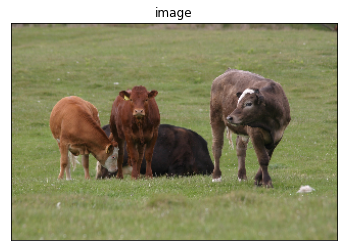

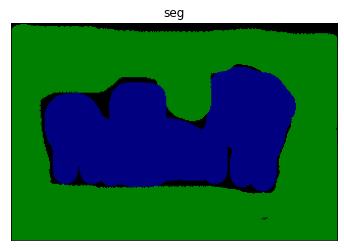

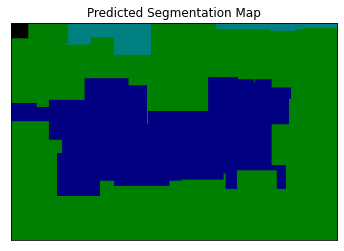

Pixel Accuracy:  83.47417840375587


In [32]:
# Evaluation
image_rgb = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_14_s.bmp')
seg_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_14_s_GT.bmp')
plot_image(image_rgb, 'image')
plot_image(seg_sample, 'seg')

segments_sample = slic(image_rgb, n_segments=100, compactness=10)
superpixel_plot(image_rgb, segments_sample, title = "SLIC Segmentation")
# Processing each image to extract rectangles from superpixels

superpixel_data = []
for region in regionprops(segments_sample):
    minr, minc, maxr, maxc = region.bbox

    # Local Zoom_______________________________________________________
    bbox_img_local = image_rgb[minr:maxr, minc:maxc]

    # Resizing the image to 224*224
    bbox_img_local = cv2.resize(bbox_img_local, (224,224), interpolation = cv2.INTER_AREA)
   
    # Proximal Zoom ~ 9 Superpixels Area__________________________________
    pminr, pminc, pmaxr, pmaxc = minr-25, minc-25, maxr+25, maxc+25
    if(pminr < 0): pminr = 0
    if(pminc < 0): pminc = 0
    if(pmaxr == image_rgb.shape[0]): pmaxr = image_rgb.shape[0]-1
    if(pmaxc == image_rgb.shape[1]): pmaxc = image_rgb.shape[1]-1

    bbox_img_proximal = image_rgb[pminr:pmaxr, pminc:pmaxc]
    bbox_img_proximal = cv2.resize(bbox_img_proximal, (224,224), interpolation = cv2.INTER_AREA)

    # Distant Zoom ~ 25 Superpixels Area__________________________________
    dminr, dminc, dmaxr, dmaxc = minr-50, minc-50, maxr+50, maxc+50
    if(dminr < 0): dminr = 0
    if(dminc < 0): dminc = 0
    if(dmaxr == image_rgb.shape[0]): dmaxr = image_rgb.shape[0]-1
    if(dmaxc == image_rgb.shape[1]): dmaxc = image_rgb.shape[1]-1

    bbox_img_distant = image_rgb[dminr:dmaxr, dminc:dmaxc]
    bbox_img_distant = cv2.resize(bbox_img_distant, (224,224), interpolation = cv2.INTER_AREA)

    # Global Zoom ~ Full image_______________________________________
    bbox_img_global = image_rgb
    bbox_img_global = cv2.resize(bbox_img_global, (224,224), interpolation = cv2.INTER_AREA)

    bbox_combined = np.stack([bbox_img_local, bbox_img_proximal, bbox_img_distant, bbox_img_global], axis=0)
    bbox_combined = np.clip(np.asarray(bbox_combined, dtype=float)/255, 0, 1)
    
    # Applying the transforms
    bbox_img = transform(bbox_combined)
  
    superpixel_data.append({'superpixel_image': bbox_img, 'superpixel_location': (minr, minc, maxr, maxc)})

dataloader = DataLoader(superpixel_data, batch_size=32, shuffle=True, num_workers=0)

predicted_seg_map = np.zeros(image_rgb.shape, dtype=np.uint8)

with torch.no_grad():
    for sample_batched in dataloader:
        images, location = sample_batched['superpixel_image'].to(device), sample_batched['superpixel_location']
        # calculate outputs by running images through the network
        outputs = model(images.float())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        for i in range(len(images)):
            rgb = label_2_rgb[int(f'{predicted[i]}')]
            minr, minc, maxr, maxc = location[0][i], location[1][i], location[2][i], location[3][i]
            predicted_seg_map[minr:maxr, minc:maxc, :] = rgb

seg_sample = cv2.cvtColor(seg_sample, cv2.COLOR_BGR2RGB)
# print(np.unique(seg_sample.reshape(-1,seg_sample.shape[-1]), axis=0, return_counts=True))
# print(np.unique(predicted_seg_map.reshape(-1,predicted_seg_map.shape[-1]), axis=0, return_counts=True))
plt.imshow(predicted_seg_map)
plt.title('Predicted Segmentation Map')
plt.show()
# Pixel accuracy 
Total_pixels = seg_sample.shape[0]*seg_sample.shape[1]

mask = np.all(predicted_seg_map == seg_sample, axis=2)
# print(mask)
TP = np.where(mask==True)
print("Pixel Accuracy: ", (len(TP[0])/Total_pixels)*100)